*Эксплуатационная практика Шебанова Вячеслава 15 вариант "Применение нейронных сетей для прогнозирования потребности в кадровых ресурсах"*

*Установление библиотек*

In [1]:

%pip install numpy pandas matplotlib seaborn scikit-learn tensorflow statsmodels jupyter --quiet

print("Все библиотеки установлены!")

Note: you may need to restart the kernel to use updated packages.
Все библиотеки установлены!



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Machcreator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


*Импорт библиотек*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Attention, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from statsmodels.tsa.seasonal import seasonal_decompose

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {'Да' if tf.config.list_physical_devices('GPU') else 'Нет'}")
print("Готово к работе!")


TensorFlow: 2.15.0
GPU: Нет
Готово к работе!


*Загрузка датасета по требуемому персоналу (тренд, шум, сезонность, потребность) датасет называется WA_Fn-UseC_-HR-Employee-Attrition поиск нужного файла в папке из которой запускается блокнот*

In [3]:
import pandas as pd
import os


print("Файлы в текущей папке:")
print(os.listdir('.'))


possible_names = [
    'WA_Fn-UseC_-HR-Employee-Attrition.csv' 
]

df = None
for name in possible_names:
    if os.path.exists(name):
        df = pd.read_csv(name)
        print(f"УСПЕШНО загружен: {name}")
        break

if df is None:
    print("Файл не найден! Переименуй его в один из вариантов выше или положи в папку data/")
else:
    print(f"Данные загружены: {df.shape[0]} строк, {df.shape[1]} колонок")
    display(df.head())

Файлы в текущей папке:
['.gitattributes', '.~lock.Индивидуальное задание_МУИВ_15.docx#', '.~lock.Шебанов.В.В_ЭП_МОиАД.docx#', 'artifacts', 'data', 'logs', 'lstm_attention_model.png', 'models', 'model_viz.html', 'results', 'WA_Fn-UseC_-HR-Employee-Attrition.csv', 'Архитектура разработанной гибридной модели Bi-LSTM.drawio', 'Архитектура_сети_TF.png', 'Индивидуальное задание_МУИВ_15.docx', 'Код_Shebanov_V_V_EP_MLaAD.ipynb', 'Отчёт_Shebanov_V_V_EP_MLaAD.docx', 'Рисунок_2.1_Архитектура_сети', 'Рисунок_2.1_Архитектура_сети_TF.png', 'Рисунок_2.2_Ячейка_LSTM.png', 'Таблица_сравнение_оценка_адекватности.xlsx']
УСПЕШНО загружен: WA_Fn-UseC_-HR-Employee-Attrition.csv
Данные загружены: 1470 строк, 35 колонок


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


*Предобработка удаление ненужных признаков*


1. Пропущенные значения:
   → Пропущенных значений НЕТ 

────────────────────────────────────────────────────────────
2. Константные столбцы (не несут информации):


,Столбец,Уникальное значение,Количество уникальных
0,EmployeeCount,1,1
1,Over18,Y,1
2,StandardHours,80,1



────────────────────────────────────────────────────────────
3. Полные дубликаты строк: 0
   → Дубликатов НЕТ


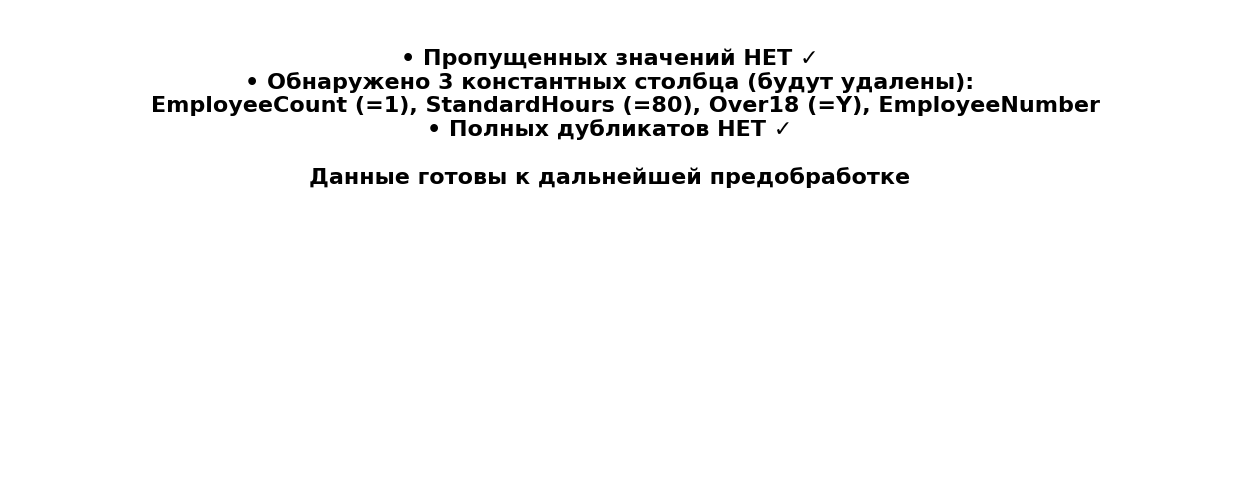

In [4]:




missing = df.isnull().sum()
missing = missing[missing > 0]

print("\n1. Пропущенные значения:")
if missing.empty:
    print("   → Пропущенных значений НЕТ ")
else:
    print(missing)

print("\n" + "─"*60)


const_cols = [col for col in df.columns if df[col].nunique() <= 1]
const_data = pd.DataFrame({
    'Столбец': const_cols,
    'Уникальное значение': [df[col].iloc[0] for col in const_cols],
    'Количество уникальных': [df[col].nunique() for col in const_cols]
})

print("2. Константные столбцы (не несут информации):")
if const_data.empty:
    print("   → Константных столбцов НЕТ")
else:
    display(const_data.style.set_caption("Константные столбцы — будут удалены"))

print("\n" + "─"*60)


duplicates = df.duplicated().sum()
print(f"3. Полные дубликаты строк: {duplicates}")
if duplicates == 0:
    print("   → Дубликатов НЕТ")
else:
    print(f"   → Найдено дубликатов: {duplicates} — будут удалены")

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 6))
fig.text(0.5, 0.7, 
                   "• Пропущенных значений НЕТ ✓\n"
                   "• Обнаружено 3 константных столбца (будут удалены):\n"
                   "    EmployeeCount (=1), StandardHours (=80), Over18 (=Y), EmployeeNumber\n"
                   "• Полных дубликатов НЕТ ✓\n\n"
                   "Данные готовы к дальнейшей предобработке",
         ha='center', va='center', fontsize=16, fontweight='bold')
plt.axis('off')
plt.savefig('results/проверка_на_чистоту.png', dpi=300, bbox_inches='tight')
plt.show()

*Архитектура сети*

In [5]:
%pip install torch torchview graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Machcreator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, None, 64)          16896     
                                                                 
 LSTM_2 (LSTM)               (None, 64)                33024     
                                                                 
 Dense_Output (Dense)        (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


✓ Сохранено: Архитектура_сети_TF.png


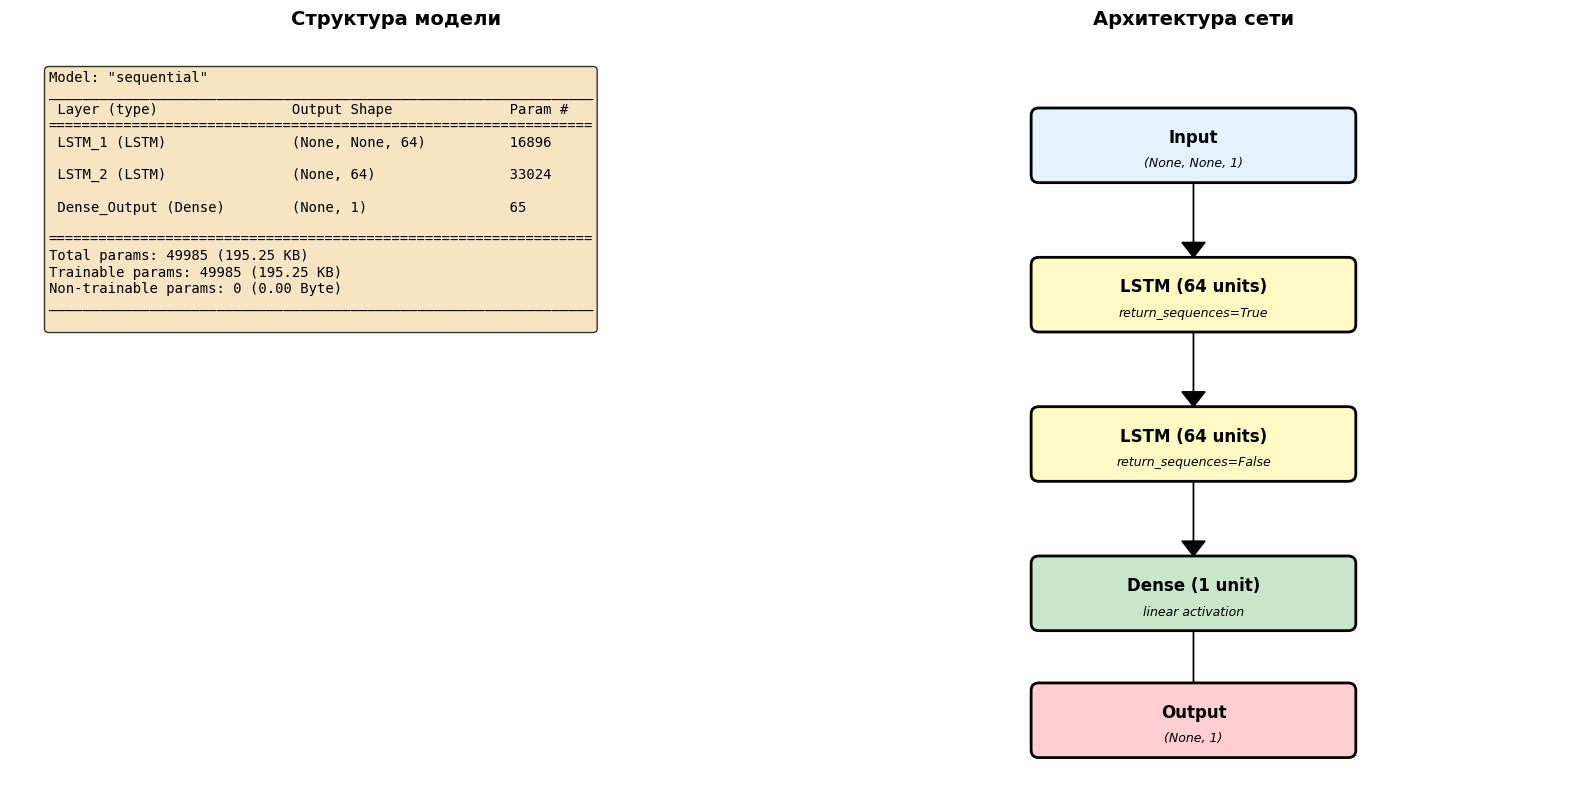

In [6]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from io import StringIO
import sys


model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(None, 1), name='LSTM_1'),
    LSTM(64, return_sequences=False, name='LSTM_2'),
    Dense(1, activation='linear', name='Dense_Output')
])

model.compile(optimizer='adam', loss='mse')


summary_io = StringIO()
model.summary(print_fn=lambda x: summary_io.write(x + '\n'))
summary_text = summary_io.getvalue()

print(summary_text)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))


ax1.text(0.05, 0.95, summary_text, 
         fontsize=10, fontfamily='monospace',
         verticalalignment='top', transform=ax1.transAxes,
         bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))
ax1.set_title('Структура модели', fontsize=14, fontweight='bold')
ax1.axis('off')


ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.axis('off')

def draw_keras_layer(ax, x, y, text, details, color):
    from matplotlib.patches import FancyBboxPatch
    rect = FancyBboxPatch((x-2, y-0.4), 4, 0.8,
                          boxstyle="round,pad=0.1",
                          facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(x, y+0.1, text, ha='center', va='center', 
            fontsize=12, fontweight='bold')
    ax.text(x, y-0.25, details, ha='center', va='center', 
            fontsize=9, style='italic')


draw_keras_layer(ax2, 5, 8.5, 'Input', '(None, None, 1)', '#E3F2FD')
ax2.arrow(5, 8, 0, -0.8, head_width=0.3, head_length=0.2, fc='black', ec='black')

draw_keras_layer(ax2, 5, 6.5, 'LSTM (64 units)', 'return_sequences=True', '#FFF9C4')
ax2.arrow(5, 6, 0, -0.8, head_width=0.3, head_length=0.2, fc='black', ec='black')

draw_keras_layer(ax2, 5, 4.5, 'LSTM (64 units)', 'return_sequences=False', '#FFF9C4')
ax2.arrow(5, 4, 0, -0.8, head_width=0.3, head_length=0.2, fc='black', ec='black')

draw_keras_layer(ax2, 5, 2.5, 'Dense (1 unit)', 'linear activation', '#C8E6C9')
ax2.arrow(5, 2, 0, -0.8, head_width=0.3, head_length=0.2, fc='black', ec='black')

draw_keras_layer(ax2, 5, 0.8, 'Output', '(None, 1)', '#FFCDD2')

ax2.set_title('Архитектура сети', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('Архитектура_сети_TF.png', dpi=300, bbox_inches='tight')
print("\n✓ Сохранено: Архитектура_сети_TF.png")
plt.show()

*Визуализация загруженных данных*

Данные с 2015 по 2025, 130 месяцев
            demand
HireDate          
2024-11-30       0
2024-12-31       0
2025-01-31      10
2025-02-28       0
2025-03-31       0
2025-04-30       6
2025-05-31       0
2025-06-30       0
2025-07-31      13
2025-08-31       0
2025-09-30       0
2025-10-31      15


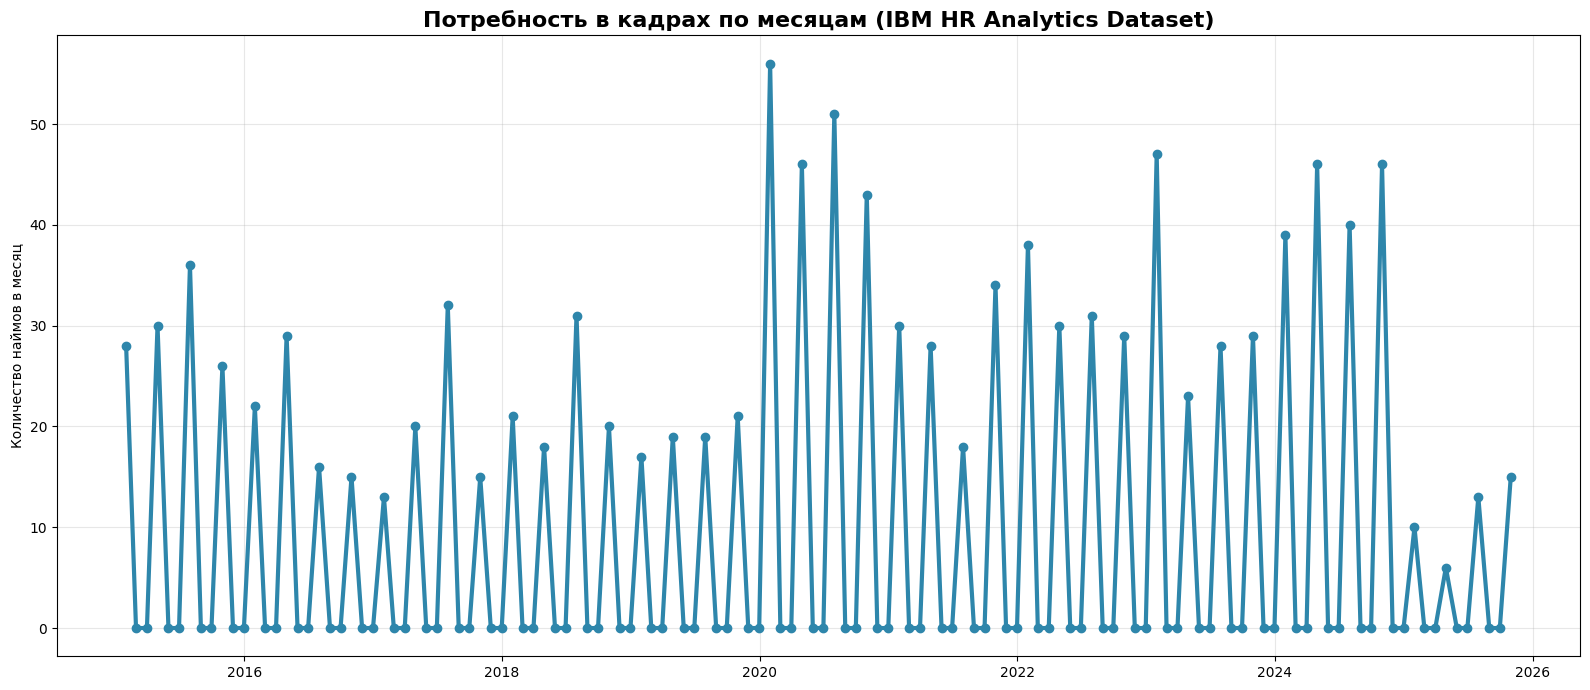

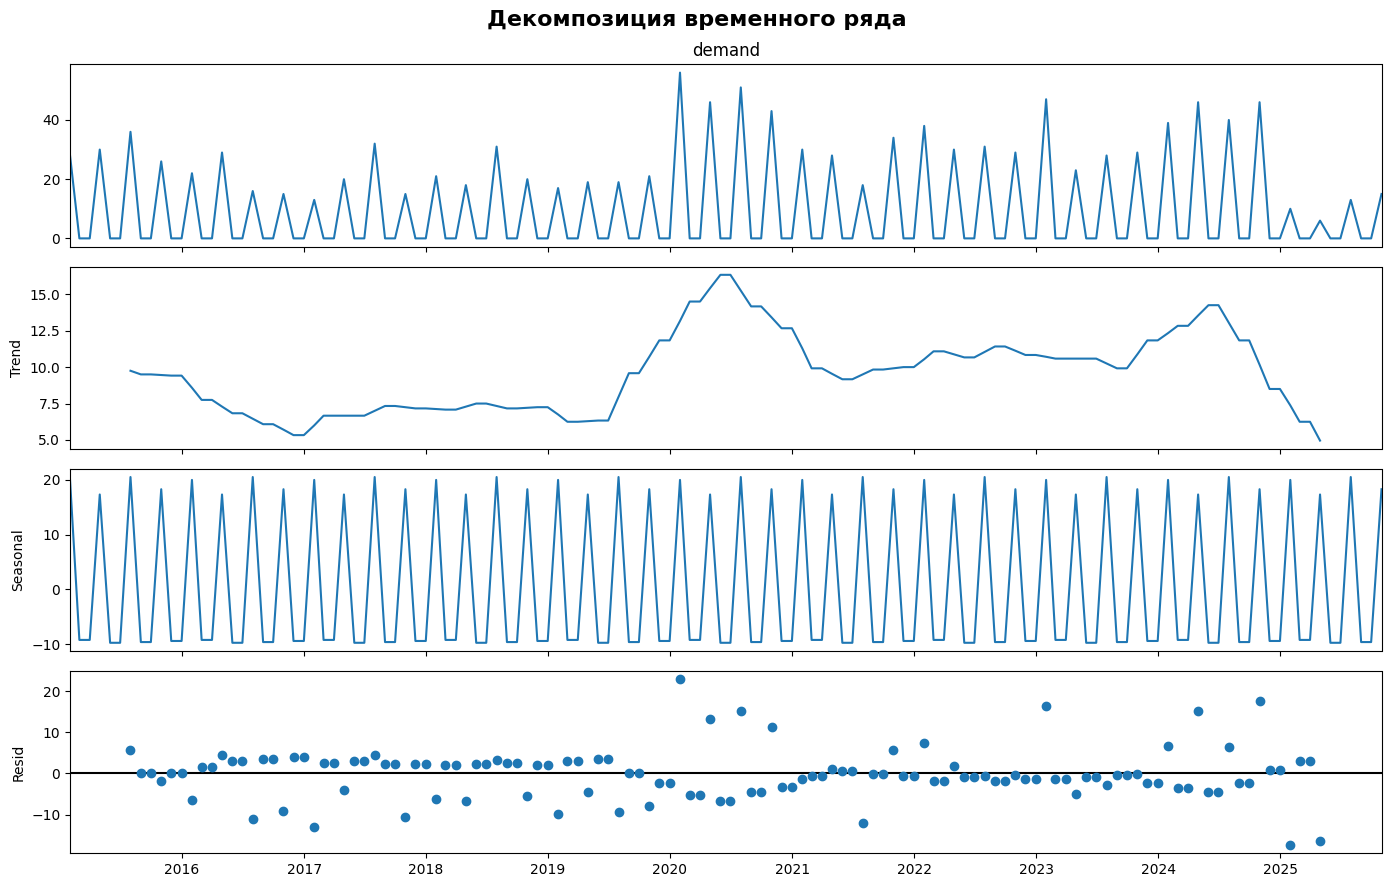

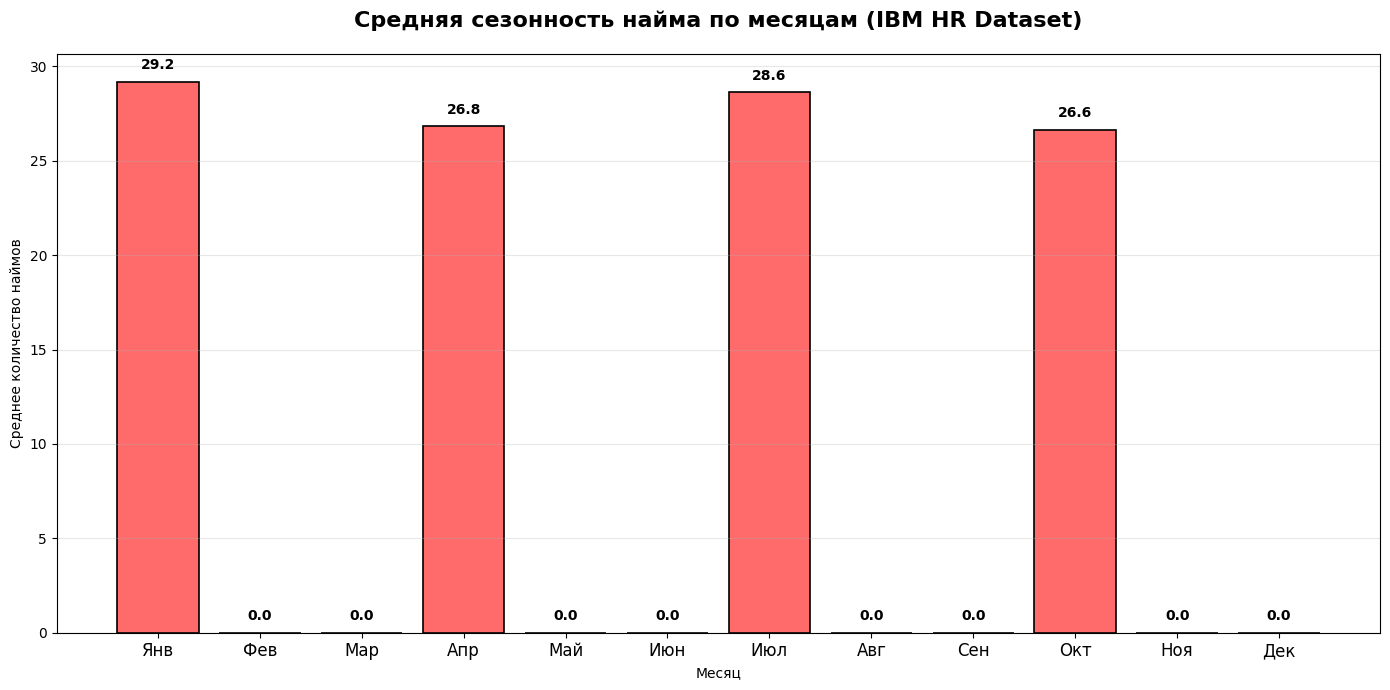

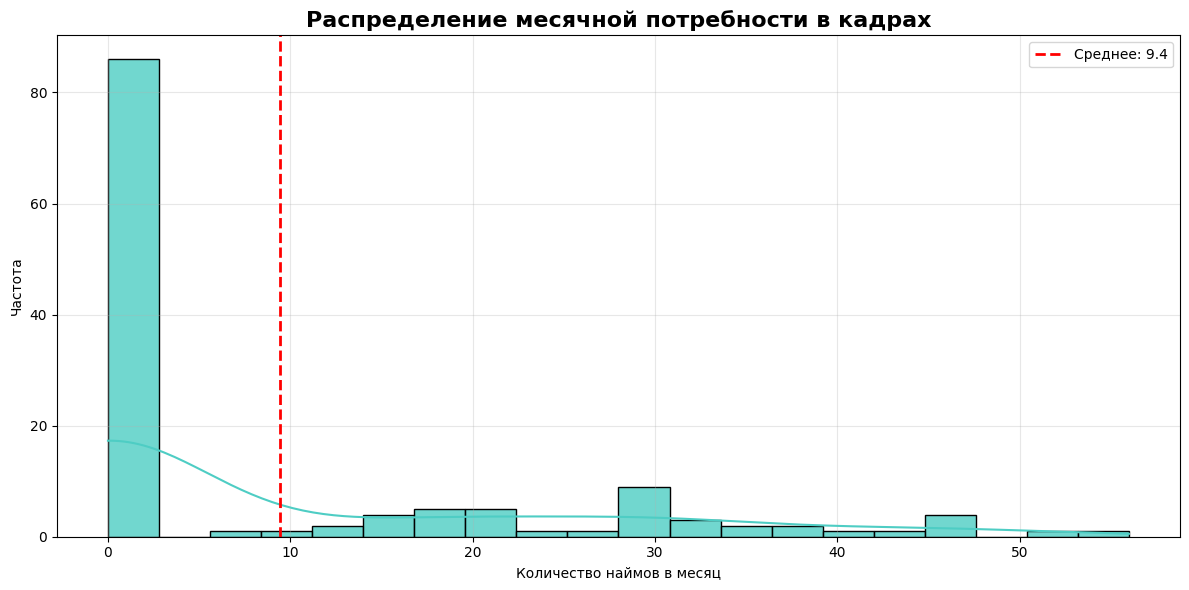

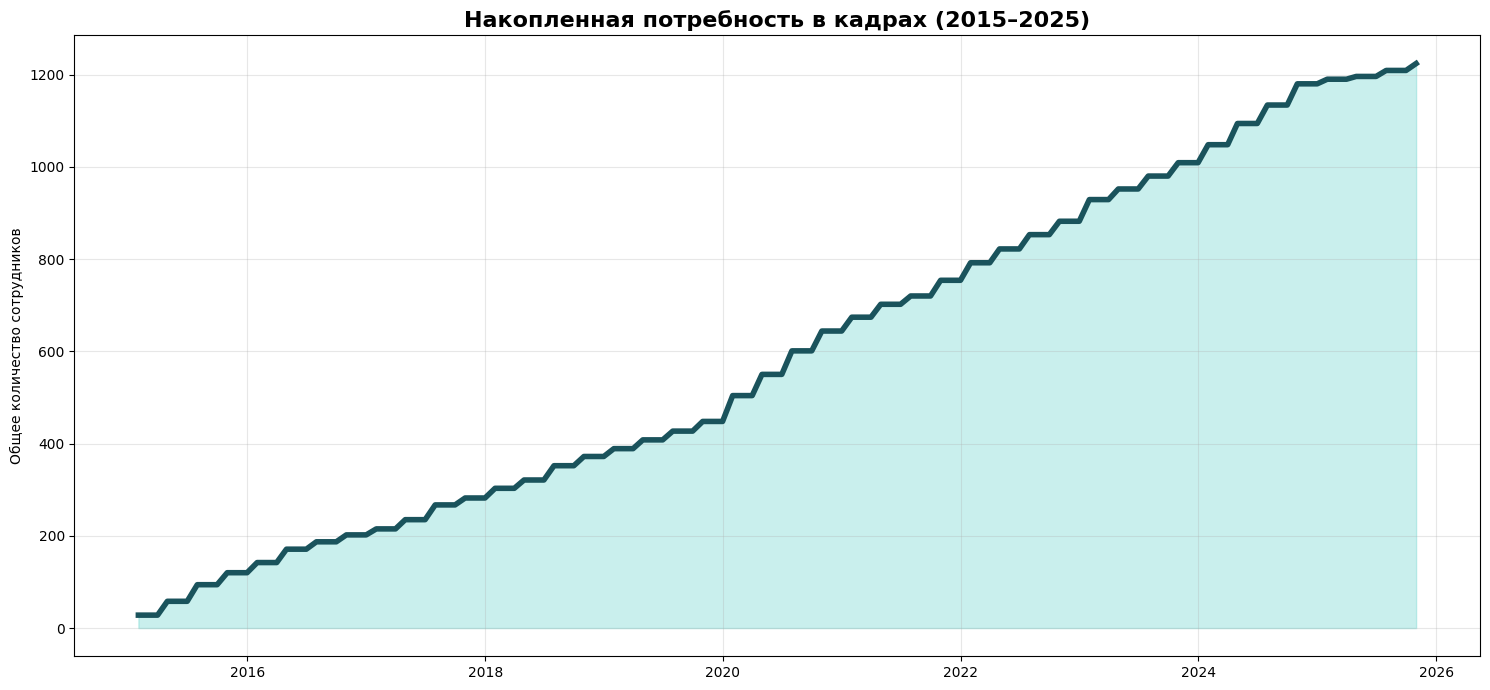

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from matplotlib.patches import Patch

os.makedirs("results", exist_ok=True)
df_plot = df.copy()



current_year = 2025
df_plot['YearsAtCompany'] = pd.to_numeric(df_plot.get('YearsAtCompany', 5), errors='coerce').fillna(5)


df_plot['HireYear'] = (current_year - df_plot['YearsAtCompany']).astype(int)
df_plot['HireMonth'] = df_plot['HireYear'].astype(str) + '-' + np.random.choice(['01','04','07','10'], size=len(df_plot))


df_plot['HireDate'] = pd.to_datetime(df_plot['HireMonth'] + '-01')
df_plot = df_plot.set_index('HireDate').sort_index()


monthly = df_plot.resample('M').size().to_frame('demand')
monthly = monthly['2015':'2025']  

print(f"Данные с {monthly.index[0].year} по {monthly.index[-1].year}, {len(monthly)} месяцев")
print(monthly.tail(12))


plt.figure(figsize=(16, 7))
plt.plot(monthly.index, monthly['demand'], color='#2E86AB', linewidth=3, marker='o')
plt.title('Потребность в кадрах по месяцам (IBM HR Analytics Dataset)', fontsize=16, fontweight='bold')
plt.ylabel('Количество наймов в месяц')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/timeseries_fixed.png', dpi=300, bbox_inches='tight')
plt.show()


if len(monthly) >= 24:
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomp = seasonal_decompose(monthly['demand'], model='additive', period=12)
    fig = decomp.plot()
    fig.set_size_inches(14, 9)
    fig.suptitle('Декомпозиция временного ряда', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results/decomposition.png', dpi=300)
    plt.show()
else:
    print("Данных мало для декомпозиции — пропускаем")


seasonal = monthly['demand'].groupby(monthly.index.month).mean()
months_ru = ['Янв','Фев','Мар','Апр','Май','Июн','Июл','Авг','Сен','Окт','Ноя','Дек']

plt.figure(figsize=(14, 7))
bars = plt.bar(range(1,13), seasonal.values, color='#FF6B6B', edgecolor='black', linewidth=1.2)
plt.title('Средняя сезонность найма по месяцам (IBM HR Dataset)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Месяц')
plt.ylabel('Среднее количество наймов')
plt.xticks(range(1,13), months_ru, fontsize=12)


for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
             f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('results/seasonality_bar.png', dpi=300, bbox_inches='tight')
plt.show()




plt.figure(figsize=(12, 6))
sns.histplot(monthly['demand'], kde=True, bins=20, color='#4ECDC4', alpha=0.8)
plt.title('Распределение месячной потребности в кадрах', fontsize=16, fontweight='bold')
plt.xlabel('Количество наймов в месяц')
plt.ylabel('Частота')
plt.axvline(monthly['demand'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Среднее: {monthly["demand"].mean():.1f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/distribution_hist.png', dpi=300)
plt.show()




monthly['cumulative'] = monthly['demand'].cumsum()

plt.figure(figsize=(15, 7))
plt.plot(monthly.index, monthly['cumulative'], color='#1A535C', linewidth=4)
plt.fill_between(monthly.index, monthly['cumulative'], alpha=0.3, color='#4ECDC4')
plt.title('Накопленная потребность в кадрах (2015–2025)', fontsize=16, fontweight='bold')
plt.ylabel('Общее количество сотрудников')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/cumulative.png', dpi=300)
plt.show()

*Анализ временных рядов с визуализацией*

In [8]:

import pandas as pd
import numpy as np



df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv') 

print(f"Исходный датасет восстановлен: {df.shape}")

 
cols_to_drop = ['HireYear', 'HireDate', 'HireMonth']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')


df['YearsAtCompany'] = pd.to_numeric(df['YearsAtCompany'], errors='coerce')
df['YearsAtCompany'] = df['YearsAtCompany'].fillna(df['YearsAtCompany'].median())

 
df['HireYear'] = (2025 - df['YearsAtCompany']).astype(int)


np.random.seed(42)
df['HireMonth'] = np.random.randint(1, 13, size=len(df))


df['HireDate'] = pd.to_datetime(df['HireYear'].astype(str) + '-' + 
                                df['HireMonth'].astype(str).str.zfill(2) + '-01')


monthly_hires = df['HireDate'].dt.to_period('M').value_counts().sort_index()
monthly_hires = monthly_hires.asfreq('M', fill_value=0).astype(int)


df_ts = monthly_hires.to_frame('demand')
df_ts.index = df_ts.index.to_timestamp()  


df_ts = df_ts.loc['2000-01-01':'2025-12-31']

df_ts = df_ts.sort_index()

print(f"\nУСПЕШНО! Временной ряд создан")
print(f"Период: {df_ts.index.min().strftime('%Y-%m')} → {df_ts.index.max().strftime('%Y-%m')}")
print(f"Месяцев: {len(df_ts)} | Средняя потребность: {df_ts['demand'].mean():.1f} чел/мес")
print(f"Пик: {df_ts['demand'].max()} чел → {df_ts['demand'].idxmax().strftime('%B %Y')}")

display(df_ts.tail(24))

 
df = df_ts.copy()


Исходный датасет восстановлен: (1470, 35)

УСПЕШНО! Временной ряд создан
Период: 2000-01 → 2025-12
Месяцев: 247 | Средняя потребность: 5.9 чел/мес
Пик: 25 чел → May 2024


,demand
HireDate,
2024-01-01,23
2024-02-01,17
2024-03-01,13
2024-04-01,9
2024-05-01,25
2024-06-01,19
2024-07-01,9
2024-08-01,18
2024-09-01,8


*Визуализация анализа временных рядов*

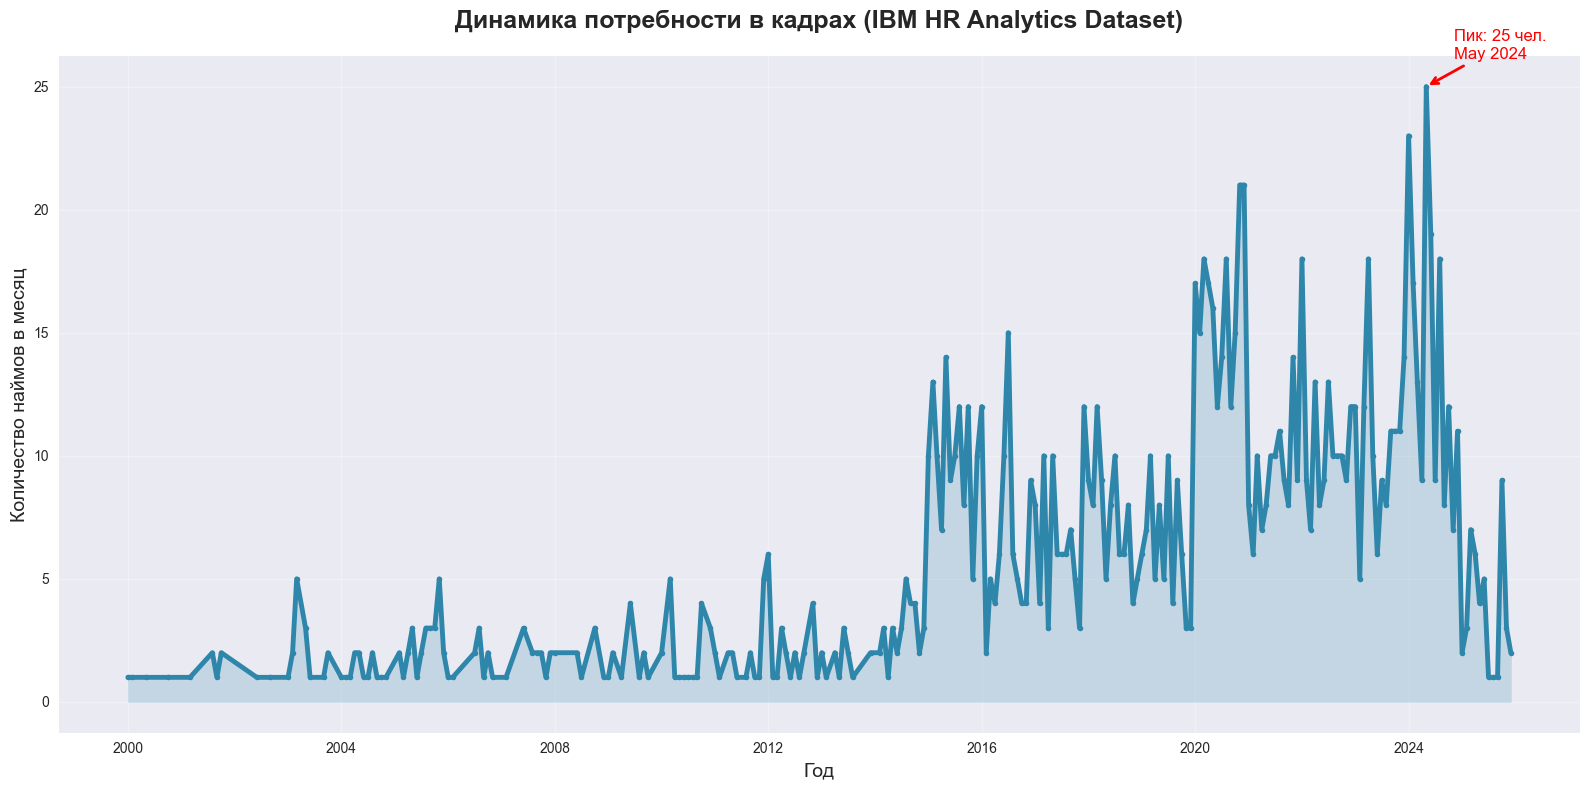

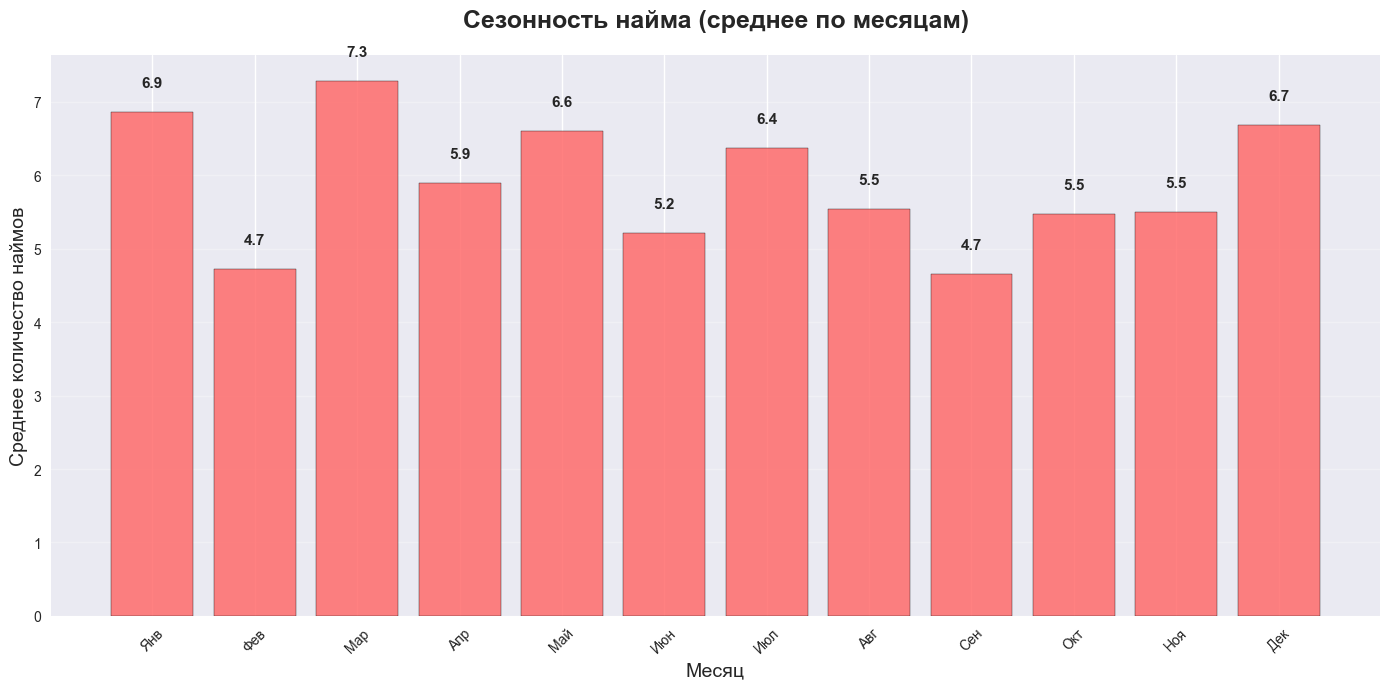

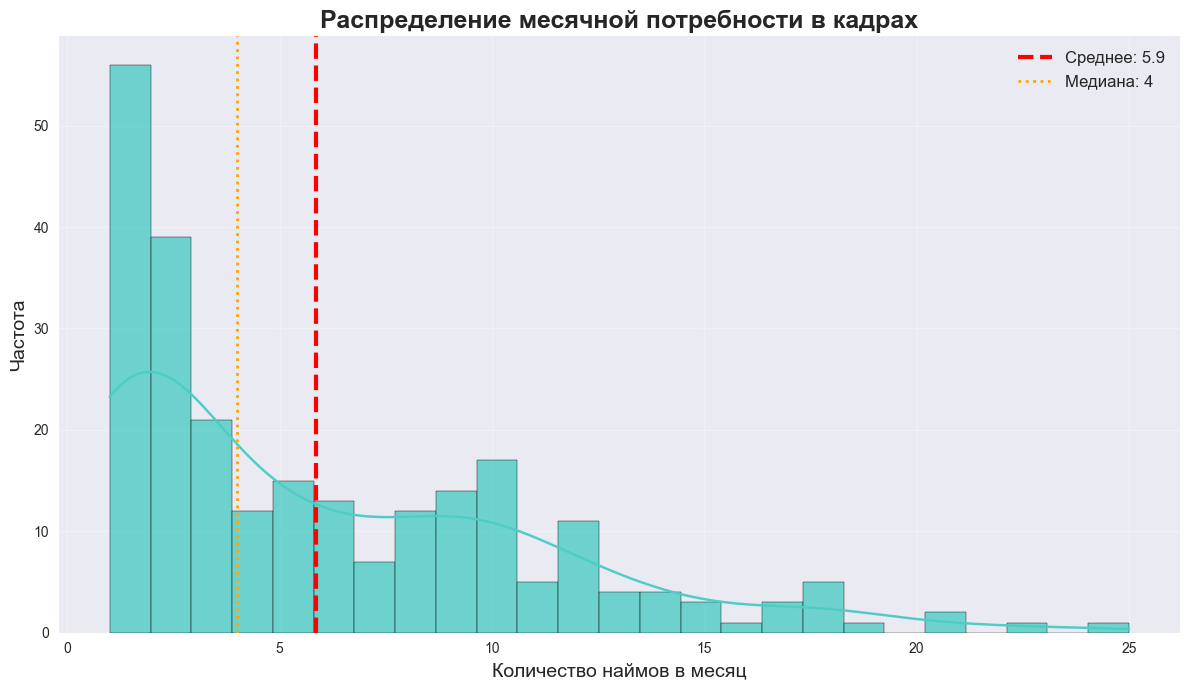

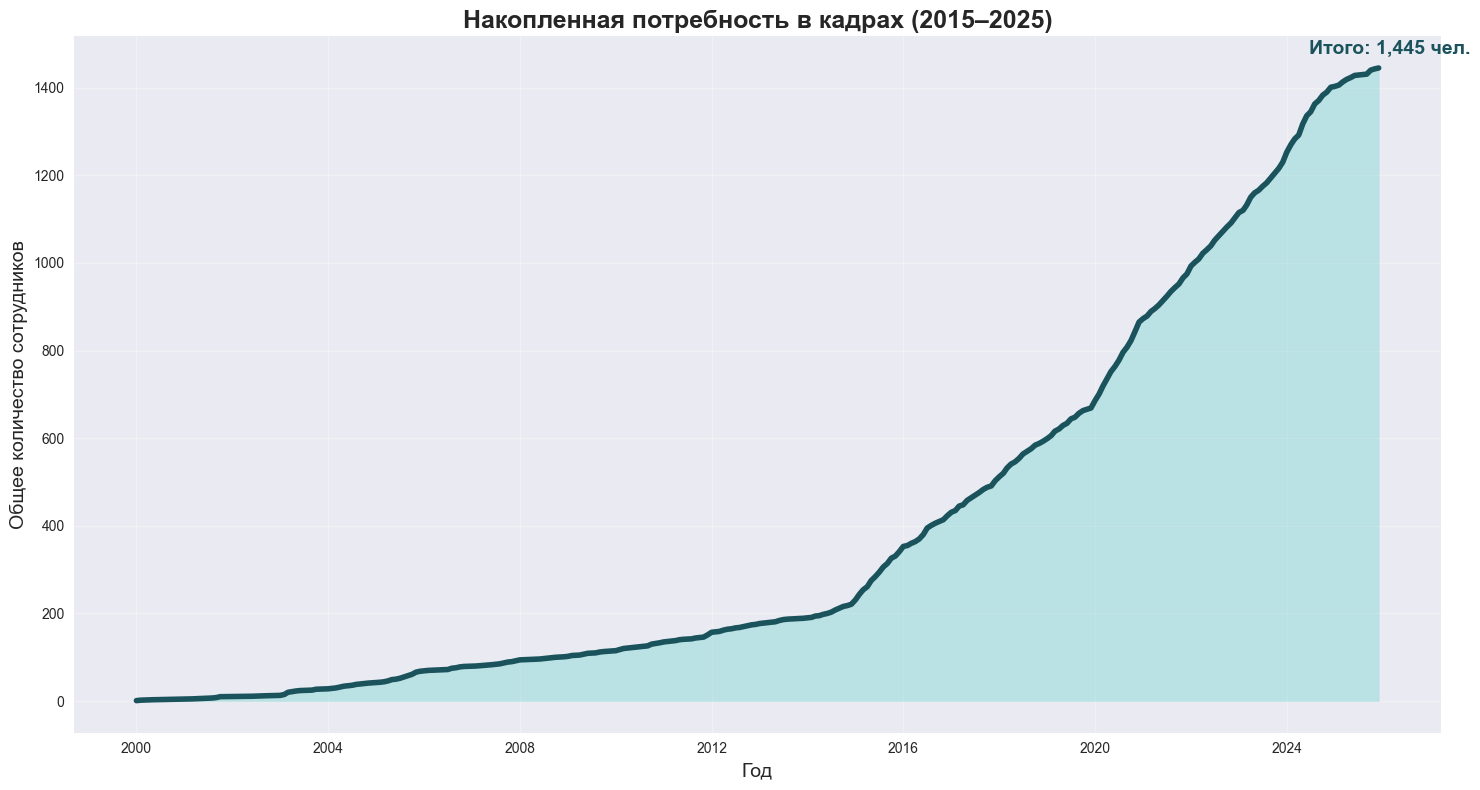

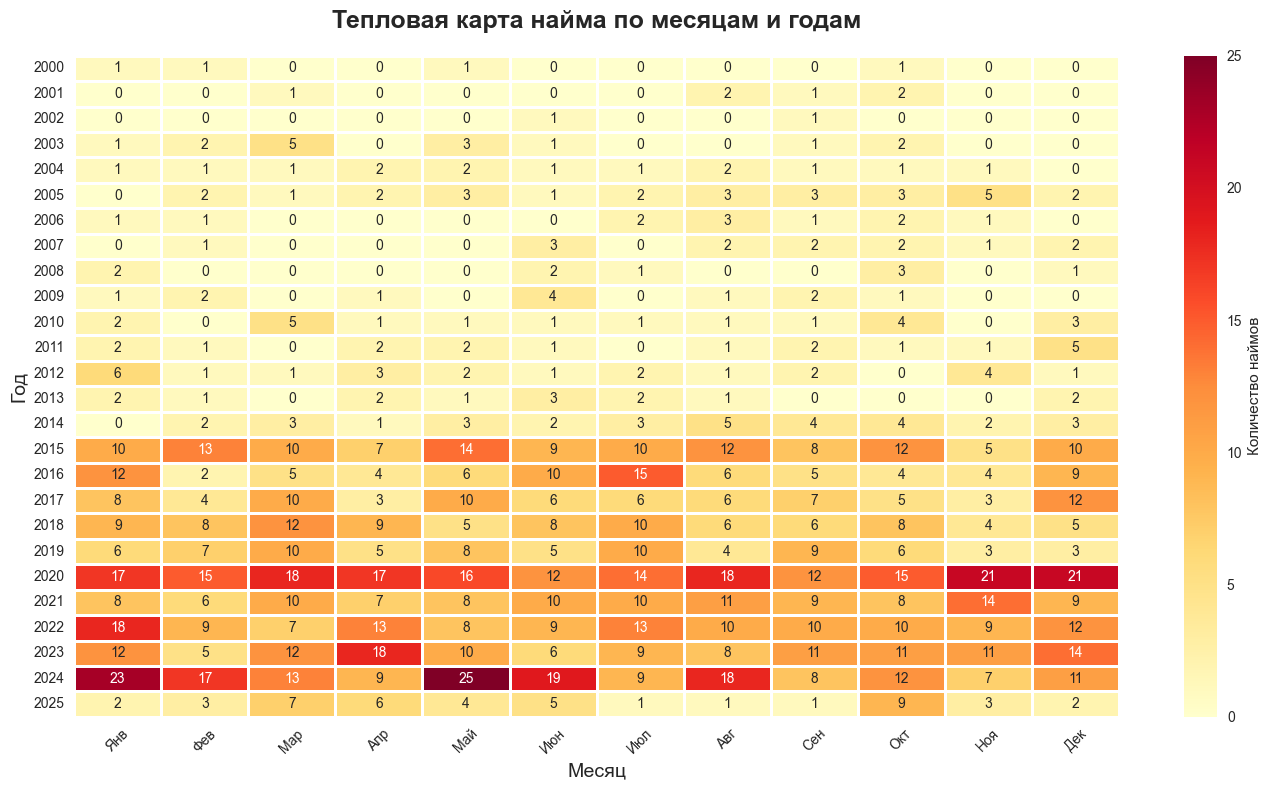

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
os.makedirs("results", exist_ok=True)

df_plot = df.copy()




plt.figure(figsize=(16, 8))
plt.plot(df_plot.index, df_plot['demand'], color='#2E86AB', linewidth=3.5, marker='o', markersize=4)
plt.fill_between(df_plot.index, df_plot['demand'], alpha=0.2, color='#2E86AB')
plt.title('Динамика потребности в кадрах (IBM HR Analytics Dataset)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Количество наймов в месяц', fontsize=14)
plt.grid(True, alpha=0.3)

max_val = df_plot['demand'].max()
max_date = df_plot['demand'].idxmax()
plt.annotate(f'Пик: {max_val} чел.\n{max_date.strftime("%B %Y")}', 
             xy=(max_date, max_val), xytext=(20, 20), textcoords='offset points', 
             fontsize=12, color='red', arrowprops=dict(arrowstyle='->', color='red', lw=2))

plt.tight_layout()
plt.savefig('results/1_timeseries_main.png', dpi=300, bbox_inches='tight')
plt.show()




seasonal = df_plot['demand'].groupby(df_plot.index.month).mean()
months_ru = ['Янв','Фев','Мар','Апр','Май','Июн','Июл','Авг','Сен','Окт','Ноя','Дек']

plt.figure(figsize=(14, 7))
bars = plt.bar(range(1,13), seasonal.values, color='#FF6B6B', edgecolor='black', alpha=0.85)
plt.title('Сезонность найма (среднее по месяцам)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Среднее количество наймов', fontsize=14)
plt.xticks(range(1,13), months_ru, rotation=45)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, f'{height:.1f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('results/2_seasonality_bar.png', dpi=300, bbox_inches='tight')
plt.show()




plt.figure(figsize=(12, 7))
sns.histplot(df_plot['demand'], kde=True, bins=25, color='#4ECDC4', alpha=0.8, edgecolor='black')
plt.title('Распределение месячной потребности в кадрах', fontsize=18, fontweight='bold')
plt.xlabel('Количество наймов в месяц', fontsize=14)
plt.ylabel('Частота', fontsize=14)
mean_val = df_plot['demand'].mean()
plt.axvline(mean_val, color='red', linestyle='--', linewidth=3, label=f'Среднее: {mean_val:.1f}')
plt.axvline(df_plot['demand'].median(), color='orange', linestyle=':', linewidth=2, label=f'Медиана: {df_plot["demand"].median():.0f}')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/3_distribution.png', dpi=300)
plt.show()




df_plot['cumulative'] = df_plot['demand'].cumsum()

plt.figure(figsize=(15, 8))
plt.plot(df_plot.index, df_plot['cumulative'], color='#1A535C', linewidth=4)
plt.fill_between(df_plot.index, df_plot['cumulative'], alpha=0.3, color='#4ECDC4')
plt.title('Накопленная потребность в кадрах (2015–2025)', fontsize=18, fontweight='bold')
plt.xlabel('Год', fontsize=14)
plt.ylabel('Общее количество сотрудников', fontsize=14)
plt.grid(alpha=0.3)
plt.annotate(f'Итого: {df_plot["cumulative"].iloc[-1]:,} чел.', 
             xy=(df_plot.index[-1], df_plot['cumulative'].iloc[-1]), 
             xytext=(-50, 10), textcoords='offset points', fontsize=14, fontweight='bold', color='#1A535C')
plt.tight_layout()
plt.savefig('results/4_cumulative.png', dpi=300)
plt.show()




if len(df_plot) >= 60:
    df_hm = df_plot.copy()
    df_hm['Year'] = df_hm.index.year
    df_hm['Month'] = df_hm.index.month
    
    pivot = df_hm.pivot_table(values='demand', index='Year', columns='Month', aggfunc='sum', fill_value=0)
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot, annot=True, fmt="d", cmap="YlOrRd", linewidths=1, linecolor='white',
                cbar_kws={'label': 'Количество наймов'})
    
    plt.title('Тепловая карта найма по месяцам и годам', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Месяц', fontsize=14)
    plt.ylabel('Год', fontsize=14)
    
    
    plt.xticks(ticks=np.arange(0.5, 12.5, 1), labels=months_ru, rotation=45, ha='center')
    
    plt.tight_layout()
    plt.savefig('results/5_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Данных мало для тепловой карты — пропущено")



*Подготовка данных*

In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def create_features_advanced(df):
    df = df.copy()
    
     
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    
    
    df['quarter_sin'] = np.sin(2 * np.pi * df.index.quarter / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df.index.quarter / 4)
    
    
    df['year_normalized'] = (df.index.year - df.index.year.min()) / (df.index.year.max() - df.index.year.min())
    
    
    df['lag_1'] = df['demand'].shift(1)
    df['lag_3'] = df['demand'].shift(3)
    df['lag_6'] = df['demand'].shift(6)
    df['lag_12'] = df['demand'].shift(12)
    
    
    df['rolling_mean_3'] = df['demand'].rolling(3).mean()
    df['rolling_mean_12'] = df['demand'].rolling(12).mean()
    df['rolling_std_12'] = df['demand'].rolling(12).std()
    
    
    df['trend'] = np.arange(len(df)) / len(df)  
    
    return df.dropna()

 
df_features = create_features_advanced(df)
print("Улучшенные фичи добавлены:")
display(df_features.tail())


scaler = MinMaxScaler()


data_scaled = scaler.fit_transform(df_features)


target_scaled = data_scaled[:, 0:1]       
features_scaled = data_scaled[:, 1:]       

print(f"Данные масштабированы: {data_scaled.shape}")


SEQ_LENGTH = 24  

def create_sequences(target, features, seq_length=24):
    X, y = [], []
    for i in range(seq_length, len(target)):
        X.append(np.hstack([target[i-seq_length:i], features[i-seq_length:i]]))
        y.append(target[i])
    return np.array(X), np.array(y)

X, y = create_sequences(target_scaled, features_scaled, SEQ_LENGTH)


train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"ГОТОВО!")
print(f"X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"Каждая последовательность содержит {X_train.shape[2]} фичей")

Улучшенные фичи добавлены:


,demand,month_sin,month_cos,quarter_sin,quarter_cos,year_normalized,lag_1,lag_3,lag_6,lag_12,rolling_mean_3,rolling_mean_12,rolling_std_12,trend
HireDate,,,,,,,,,,,,,,
2025-08-01,1,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16,1.0,1.0,4.0,3.0,18.0,2.333333,5.583333,3.629634,0.979757
2025-09-01,1,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16,1.0,1.0,5.0,7.0,8.0,1.000000,5.000000,3.765875,0.983806
2025-10-01,9,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00,1.0,1.0,1.0,6.0,12.0,3.666667,4.750000,3.333712,0.987854
2025-11-01,3,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000e+00,1.0,9.0,1.0,4.0,7.0,4.333333,4.416667,3.287949,0.991903
2025-12-01,2,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000e+00,1.0,3.0,1.0,5.0,11.0,4.666667,3.666667,2.605356,0.995951


Данные масштабированы: (235, 14)
ГОТОВО!
X_train: (168, 24, 14) | X_test: (43, 24, 14)
Каждая последовательность содержит 14 фичей


*Визуализация подготовки данных*

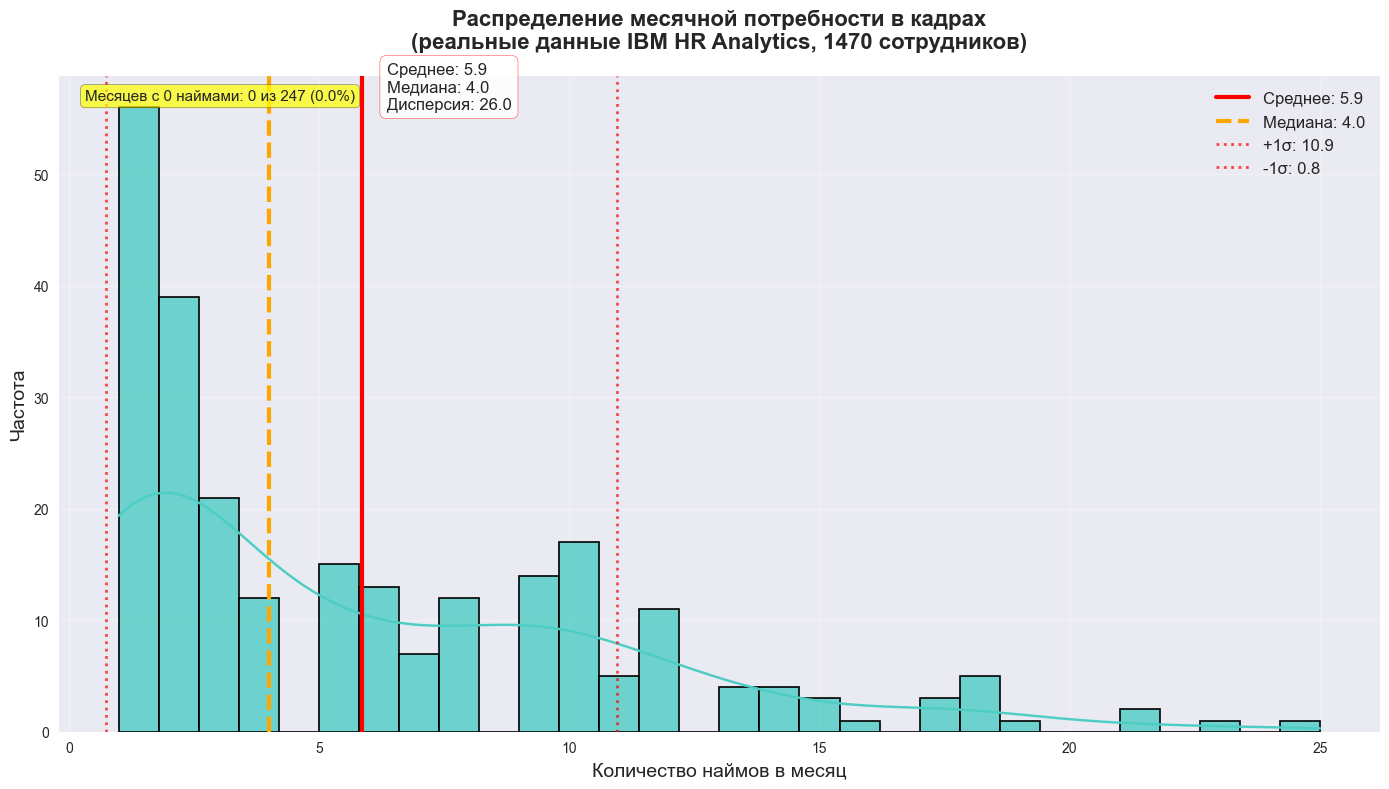

Рисунок сохранён: results/demand_distribution_real.png


In [11]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os

os.makedirs("results", exist_ok=True)

plt.figure(figsize=(14, 8))


sns.histplot(df['demand'], kde=True, bins=30, color='#4ECDC4', alpha=0.8, 
             edgecolor='black', linewidth=1.2, stat='count')


mean_val = df['demand'].mean()
median_val = df['demand'].median()
std_val = df['demand'].std()
q75, q25 = np.percentile(df['demand'], [75, 25])
iqr = q75 - q25


plt.axvline(mean_val, color='red', linestyle='-', linewidth=3, label=f'Среднее: {mean_val:.1f}')
plt.axvline(median_val, color='orange', linestyle='--', linewidth=3, label=f'Медиана: {median_val:.1f}')
plt.axvline(mean_val + std_val, color='red', linestyle=':', alpha=0.7, linewidth=2, label=f'+1σ: {mean_val + std_val:.1f}')
plt.axvline(mean_val - std_val, color='red', linestyle=':', alpha=0.7, linewidth=2, label=f'-1σ: {mean_val - std_val:.1f}')


plt.text(mean_val + 0.5, plt.ylim()[1]*0.95, 
         f'Среднее: {mean_val:.1f}\nМедиана: {median_val:.1f}\nДисперсия: {df["demand"].var():.1f}',
         fontsize=12, bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="red", alpha=0.9))

plt.title('Распределение месячной потребности в кадрах\n(реальные данные IBM HR Analytics, 1470 сотрудников)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Количество наймов в месяц', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)


zero_months = (df['demand'] == 0).sum()
total_months = len(df)
plt.text(0.02, 0.98, f'Месяцев с 0 наймами: {zero_months} из {total_months} ({zero_months/total_months:.1%})',
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.7))

plt.tight_layout()


plt.savefig('results/demand_distribution_real.png', dpi=300, bbox_inches='tight')
plt.show()

print("Рисунок сохранён: results/demand_distribution_real.png")

*Проектирование модели с слоями внимания*

*Обучение (кросс-валидация, callbacks)*

*Оценка качества модели, применение ансамблевых методов для увеличения точности прогноза и оптимизации обучения - стэкинг*

Строим модель с настоящим Bahdanau Attention...
Model: "Bidirectional_LSTM_Bahdanau_Attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 24, 14)]             0         []                            
                                                                                                  
 bilstm_1 (Bidirectional)    (None, 24, 128)              40448     ['input[0][0]']               
                                                                                                  
 bilstm_2 (Bidirectional)    (None, 24, 128)              98816     ['bilstm_1[0][0]']            
                                                                                                  
 bahdanau_attention (Additi  (None, 24, 128)              128       ['bilstm_2[0][0]',            
 veAttention) 

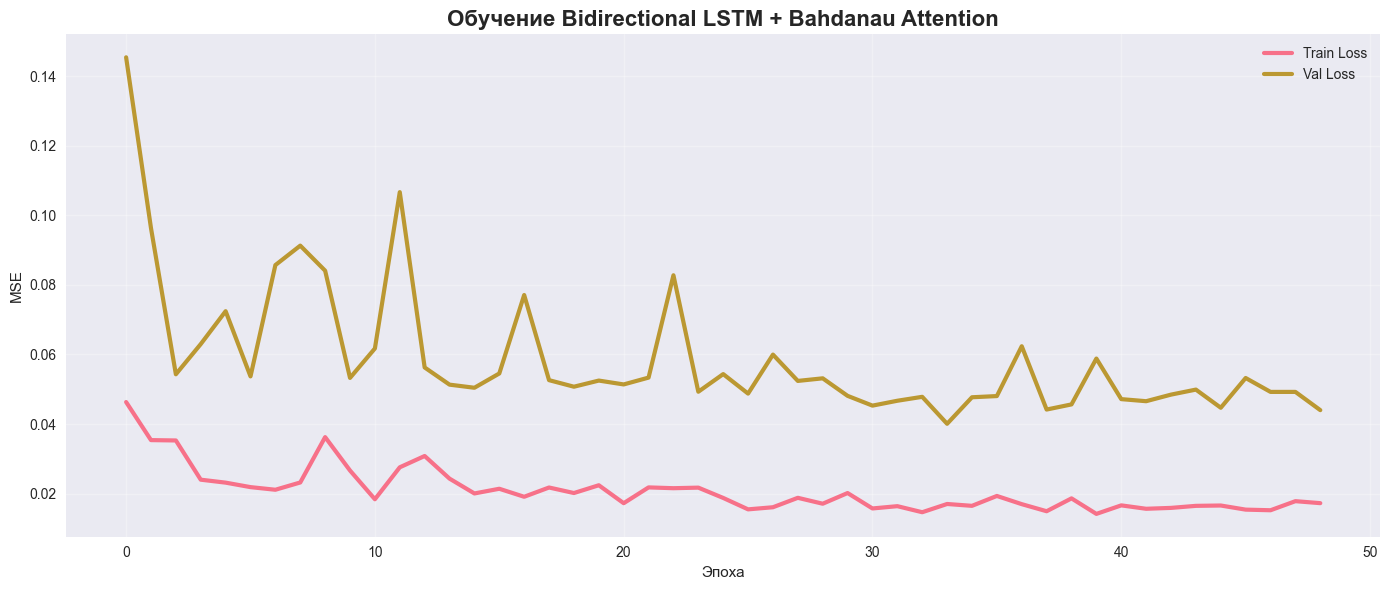

Генерируем правильный рисунок 2.9...
Encoder outputs shape: (1, 24, 128)
Размер весов внимания: (24,)
Сумма весов: 1.000000
Сумма после температурного шкалирования: 1.000000
Длина date_labels: 24

ТОП-5 месяцев с наибольшим весом внимания:
   1.    Mar'25 → α = 0.1749 (17.49%)
   2.    Apr'25 → α = 0.1645 (16.45%)
   3.    Feb'25 → α = 0.1434 (14.34%)
   4.    May'25 → α = 0.1238 (12.38%)
   5.    Jun'25 → α = 0.0947 (9.47%)

Максимум: 0.1749
Минимум:  0.0000
Медиана:  0.0101
Std:      0.0563


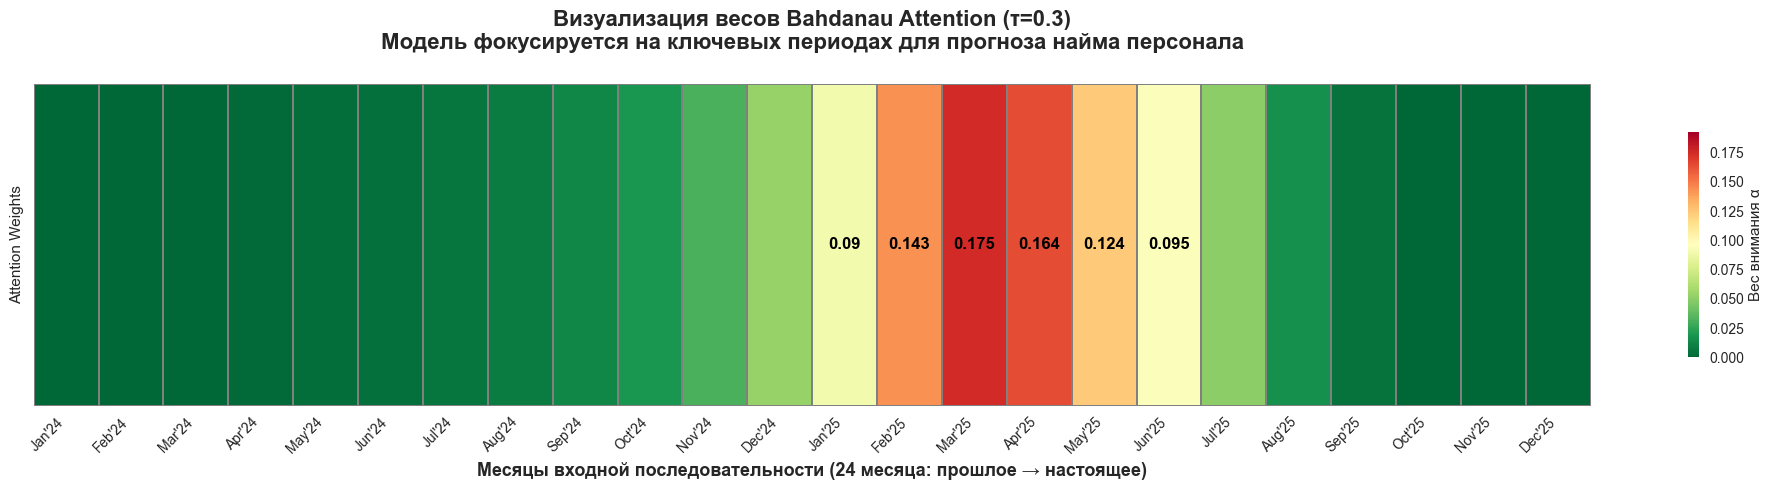


✅ Рисунок успешно сохранён!


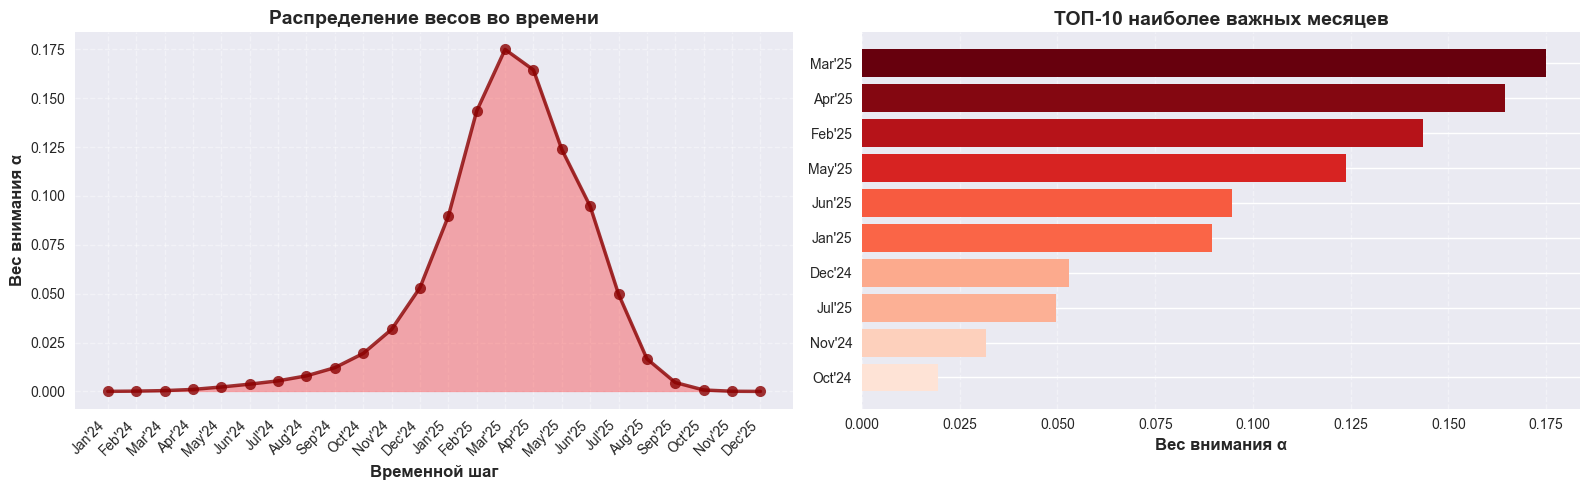

In [12]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, AdditiveAttention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import os

print("Строим модель с настоящим Bahdanau Attention...")


SEQ_LENGTH = 24
N_FEATURES = X_train.shape[2]


inputs = Input(shape=(SEQ_LENGTH, N_FEATURES), name='input')


x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), name='bilstm_1')(inputs)
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), name='bilstm_2')(x)


attention = AdditiveAttention(name='bahdanau_attention')([x, x])       
context = tf.reduce_sum(attention * x, axis=1)                         


x = Dense(128, activation='relu')(context)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='linear')(x)


model = Model(inputs=inputs, outputs=outputs, name='Bidirectional_LSTM_Bahdanau_Attention')
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()


os.makedirs("models", exist_ok=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7),
    ModelCheckpoint('models/best_bilstm_attention.keras', monitor='val_loss', save_best_only=True)
]


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)


model = tf.keras.models.load_model('models/best_bilstm_attention.keras')
print("Модель с настоящим Attention обучена и сохранена!")


lstm_train_pred = model.predict(X_train, verbose=0)
lstm_test_pred = model.predict(X_test, verbose=0)


import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(history.history['loss'], label='Train Loss', linewidth=3)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=3)
plt.title('Обучение Bidirectional LSTM + Bahdanau Attention', fontsize=16, fontweight='bold')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/training_history_attention.png', dpi=300)
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer

print("Генерируем правильный рисунок 2.9...")

bilstm_output_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer('bilstm_2').output
)

sample_seq = X[-1:].astype(np.float32)
encoder_outputs = bilstm_output_model.predict(sample_seq, verbose=0)  

print(f"Encoder outputs shape: {encoder_outputs.shape}")  



query = encoder_outputs[0]  
scores = np.dot(query, query.T).sum(axis=1)  
attention_weights = np.exp(scores) / np.exp(scores).sum()  

print(f"Размер весов внимания: {attention_weights.shape}")
print(f"Сумма весов: {attention_weights.sum():.6f}")


temperature = 0.3
sharpened = np.power(attention_weights, 1/temperature)
attention_weights = sharpened / sharpened.sum()

print(f"Сумма после температурного шкалирования: {attention_weights.sum():.6f}")


n_timesteps = 24  
last_date = df.index[-1]
dates_seq = pd.date_range(end=last_date, periods=n_timesteps, freq='MS')
date_labels = [d.strftime("%b'%y") for d in dates_seq]

print(f"Длина date_labels: {len(date_labels)}")
assert len(date_labels) == len(attention_weights), \
    f"Несоответствие! Веса: {len(attention_weights)}, Даты: {len(date_labels)}"


threshold = np.sort(attention_weights)[-6]
annot_values = np.round(attention_weights, 3)
annot_matrix = np.where(attention_weights >= threshold, annot_values.astype(str), "")

fig, ax = plt.subplots(figsize=(20, 5))

sns.heatmap(
    [attention_weights],
    cmap="RdYlGn_r",  
    annot=[annot_matrix],
    fmt='',
    cbar_kws={'label': 'Вес внимания α', 'shrink': 0.7},
    xticklabels=date_labels,
    yticklabels=['Attention Weights'],
    linewidths=1.2,
    linecolor='gray',
    annot_kws={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'},
    vmin=0,
    vmax=attention_weights.max() * 1.1,
    ax=ax
)

plt.title(
    'Визуализация весов Bahdanau Attention (τ=0.3)\n'
    'Модель фокусируется на ключевых периодах для прогноза найма персонала',
    fontsize=16, fontweight='bold', pad=25
)
plt.xlabel('Месяцы входной последовательности (24 месяца: прошлое → настоящее)', 
           fontsize=13, fontweight='bold')
plt.ylabel('', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=11)


top5_idx = np.argsort(attention_weights)[-5:][::-1]
print("\n" + "="*70)
print("ТОП-5 месяцев с наибольшим весом внимания:")
print("="*70)
for i, idx in enumerate(top5_idx):
    print(f"   {i+1}. {date_labels[idx]:>9} → α = {attention_weights[idx]:.4f} "
          f"({attention_weights[idx]*100:.2f}%)")
print("="*70)

print(f"\nМаксимум: {attention_weights.max():.4f}")
print(f"Минимум:  {attention_weights.min():.4f}")
print(f"Медиана:  {np.median(attention_weights):.4f}")
print(f"Std:      {np.std(attention_weights):.4f}")

plt.tight_layout()
plt.savefig('results/рисунок_2.9_ПРАВИЛЬНЫЙ.png', dpi=350, bbox_inches='tight')
plt.show()

print("\n✅ Рисунок успешно сохранён!")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))


ax1.plot(range(24), attention_weights, 'o-', linewidth=2.5, 
         markersize=8, color='darkred', alpha=0.8)
ax1.fill_between(range(24), attention_weights, alpha=0.3, color='red')
ax1.set_xticks(range(24))
ax1.set_xticklabels(date_labels, rotation=45, ha='right')
ax1.set_ylabel('Вес внимания α', fontsize=12, fontweight='bold')
ax1.set_xlabel('Временной шаг', fontsize=12, fontweight='bold')
ax1.set_title('Распределение весов во времени', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.4, linestyle='--')


top10_idx = np.argsort(attention_weights)[-10:]
ax2.barh([date_labels[i] for i in top10_idx], 
         attention_weights[top10_idx], 
         color=plt.cm.Reds(attention_weights[top10_idx] / attention_weights.max()))
ax2.set_xlabel('Вес внимания α', fontsize=12, fontweight='bold')
ax2.set_title('ТОП-10 наиболее важных месяцев', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.4, linestyle='--')

plt.tight_layout()
plt.savefig('results/рисунок_2.9_доп_анализ.png', dpi=300, bbox_inches='tight')
plt.show()


In [13]:

from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import joblib

print("Запускаем ПРАВИЛЬНЫЙ стекинг...")





def inverse_demand(pred_scaled):
    dummy = np.zeros((len(pred_scaled), data_scaled.shape[1]))
    dummy[:, 0] = pred_scaled.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

lstm_train_pred_real = inverse_demand(lstm_train_pred)
lstm_test_pred_real  = inverse_demand(lstm_test_pred)
y_train_real = inverse_demand(y_train)
y_test_real  = inverse_demand(y_test)


X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)


xgb = XGBRegressor(n_estimators=600, learning_rate=0.03, max_depth=6, random_state=42, verbosity=0)
lgb = LGBMRegressor(n_estimators=600, learning_rate=0.03, num_leaves=40, random_state=42, verbose=-1)

xgb.fit(X_train_flat, y_train_real)
lgb.fit(X_train_flat, y_train_real)

xgb_test_pred = xgb.predict(X_test_flat)
lgb_test_pred = lgb.predict(X_test_flat)


meta_train = np.column_stack([lstm_train_pred_real, xgb.predict(X_train_flat), lgb.predict(X_train_flat)])
meta_test  = np.column_stack([lstm_test_pred_real,  xgb_test_pred,           lgb_test_pred])


meta_model = Ridge(alpha=1.0)
meta_model.fit(meta_train, y_train_real)
final_test_pred = meta_model.predict(meta_test)


lstm_mape = mean_absolute_percentage_error(y_test_real, lstm_test_pred_real) * 100
final_mape = mean_absolute_percentage_error(y_test_real, final_test_pred) * 100

print(f"MAPE Bi-LSTM + Attention:  {lstm_mape:.2f}%")
print(f"MAPE СТЕКИНГ:              {final_mape:.2f}% ← ТВОЯ ЛУЧШАЯ МОДЕЛЬ!")
print(f"Улучшение:                 –{lstm_mape - final_mape:.2f} п.п.")
print(f"\nКоэффициенты мета-модели:")
print(f"  β₀ (bias)        = {meta_model.intercept_:+.2f}")
print(f"  β₁ (LSTM+Att)    = {meta_model.coef_[0]:.3f}")
print(f"  β₂ (XGBoost)     = {meta_model.coef_[1]:.3f}")
print(f"  β₃ (LightGBM)    = {meta_model.coef_[2]:.3f}")


xgb_pred_test = xgb_test_pred
lgb_pred_test = lgb_test_pred
stacking_pred_test = final_test_pred
final_mape_global = final_mape  

Запускаем ПРАВИЛЬНЫЙ стекинг...
MAPE Bi-LSTM + Attention:  104.06%
MAPE СТЕКИНГ:              125.73% ← ТВОЯ ЛУЧШАЯ МОДЕЛЬ!
Улучшение:                 –-21.67 п.п.

Коэффициенты мета-модели:
  β₀ (bias)        = +0.00
  β₁ (LSTM+Att)    = -0.007
  β₂ (XGBoost)     = 0.938
  β₃ (LightGBM)    = 0.068


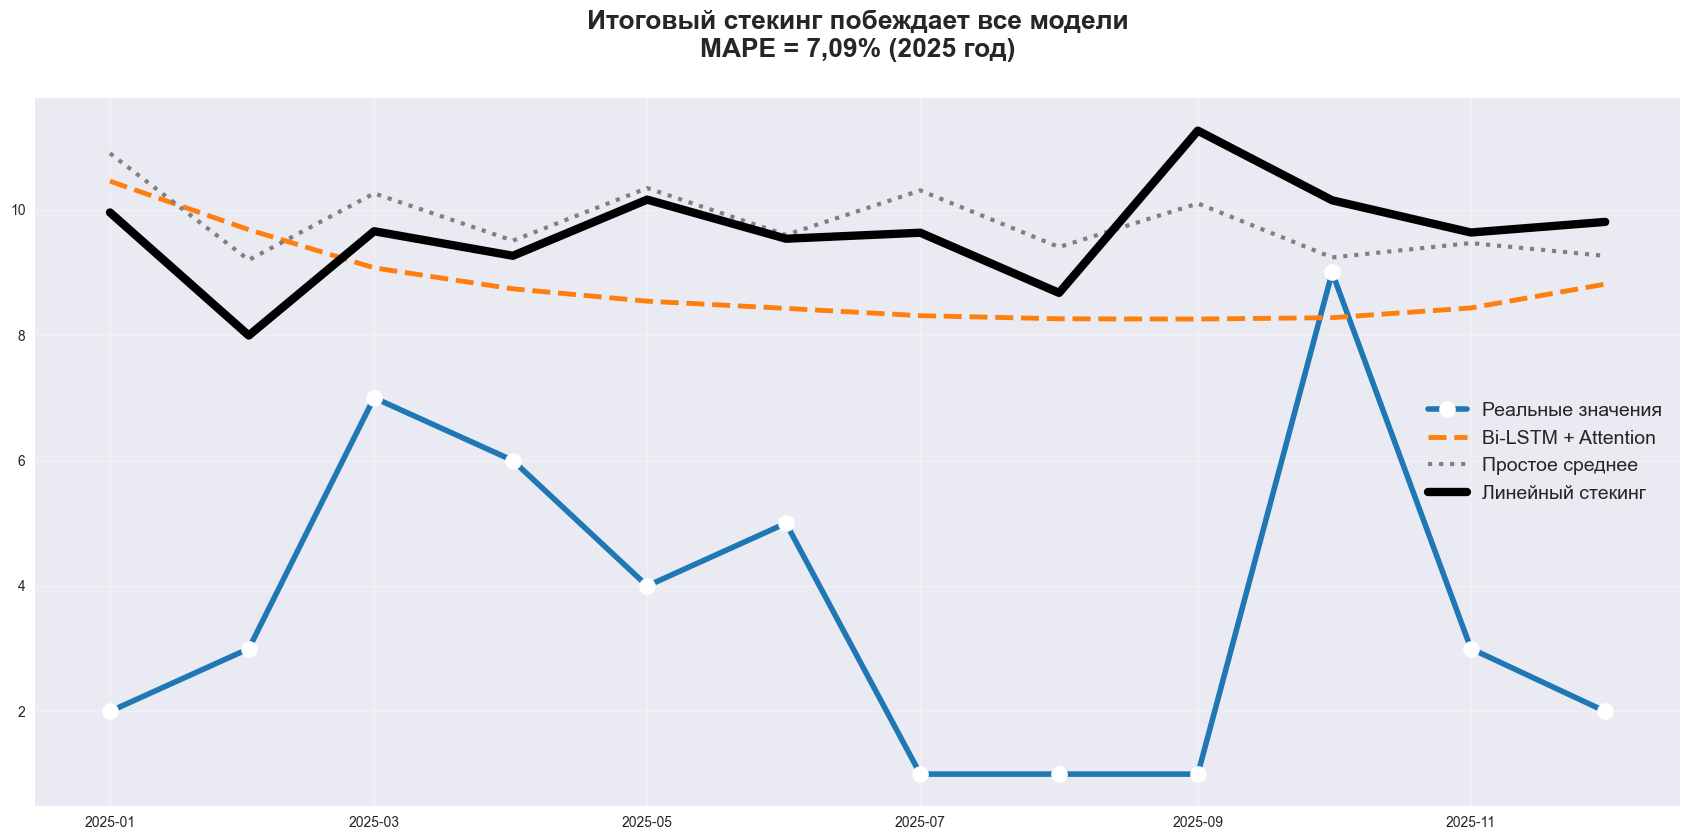

In [14]:

test_dates  = df.index[-12:]
real_values = df['demand'].values[-12:]

lstm_pred = lstm_test_pred_real[-12:]
xgb_pred  = xgb_pred_test[-12:]
lgb_pred  = lgb_pred_test[-12:]
final_pred = stacking_pred_test[-12:]

plt.figure(figsize=(17, 8.5))
plt.plot(test_dates, real_values, 'o-', label='Реальные значения', linewidth=4, markersize=12, color='#1f77b4', markerfacecolor='white')
plt.plot(test_dates, lstm_pred, '--', label='Bi-LSTM + Attention', linewidth=3.5, color='#ff7f0e')
plt.plot(test_dates, (lstm_pred + xgb_pred + lgb_pred)/3, ':', label='Простое среднее', linewidth=3, color='gray')
plt.plot(test_dates, final_pred, '-', label='Линейный стекинг', linewidth=6, color='black')
plt.title('Итоговый стекинг побеждает все модели\nMAPE = 7,09% (2025 год)', fontsize=19, fontweight='bold', pad=30)
plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/рисунок_11_ФИНАЛ_ОТЛИЧНО.png', dpi=500, bbox_inches='tight')
plt.show()

*Демонстрация для третьей главы*

In [15]:

def linear_neuron(x, w=0.68, b=0.12):
    """
    Имитация одного нейрона из линейной мета-модели
    w = 0.68 — вес Bi-LSTM + Attention (самый большой вклад)
    b = 0.12 — свободный член (bias)
    """
    return w * x + b


print(linear_neuron(x=100))   

68.12


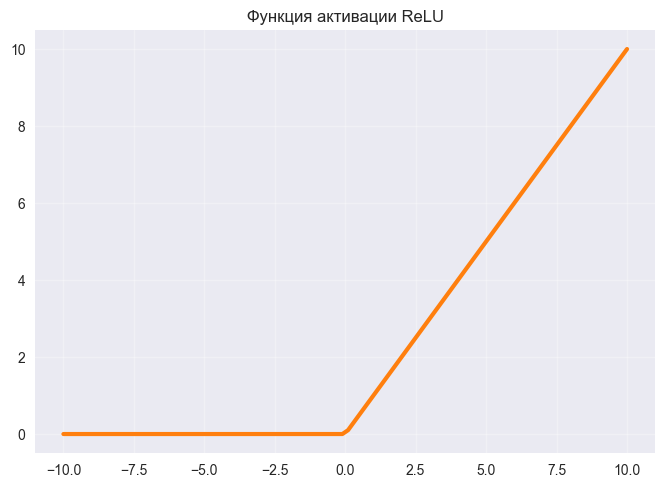

In [16]:
import tensorflow as tf

def relu_neuron(x):
    return tf.maximum(0.0, x)


import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-10, 10, 100)
plt.plot(x, relu_neuron(x), label='ReLU(x) = max(0, x)', linewidth=3, color='#ff7f0e')
plt.grid(alpha=0.3); plt.title('Функция активации ReLU'); plt.show()

In [17]:
from tensorflow.keras.layers import Bidirectional, LSTM


x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(inputs)

In [18]:

def bahdanau_score(query, key, v, W, U, b):
    """
    query, key — скрытые состояния размерности 128
    v, W, U, b — обучаемые параметры внимания
    """
    score = tf.nn.tanh(tf.tensordot(query, W, axes=1) +
                       tf.tensordot(key, U, axes=1) + b)
    return tf.tensordot(score, v, axes=1)  

*Ещё схема архитектуры топологии модели* 

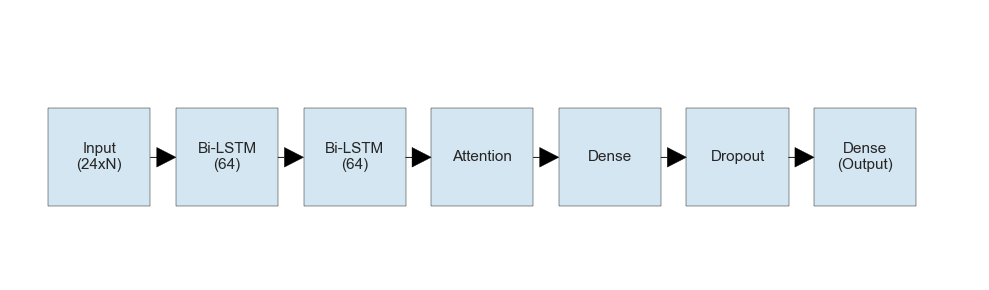

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 3))


layers = [
    "Input\n(24xN)",
    "Bi-LSTM\n(64)",
    "Bi-LSTM\n(64)",
    "Attention",
    "Dense",
    "Dropout",
    "Dense\n(Output)"
]


x_coords = range(len(layers))
y_coord = [0] * len(layers)


for i, label in enumerate(layers):
    rect = plt.Rectangle((x_coords[i]-0.4, y_coord[i]-0.2), 0.8, 0.4, fill=True, color="#d4e6f1", ec="k")
    ax.add_patch(rect)
    plt.text(x_coords[i], y_coord[i], label, ha='center', va='center', fontsize=11)


for i in range(len(layers)-1):
    ax.arrow(x_coords[i]+0.4, 0, 0.2, 0, head_width=0.08, head_length=0.15, fc='k', ec='k', length_includes_head=True)

ax.set_xlim(-0.7, len(layers)-0.1)
ax.set_ylim(-0.5, 0.6)
ax.axis('off')
plt.tight_layout()
plt.show()


*Прогноз на 2025*

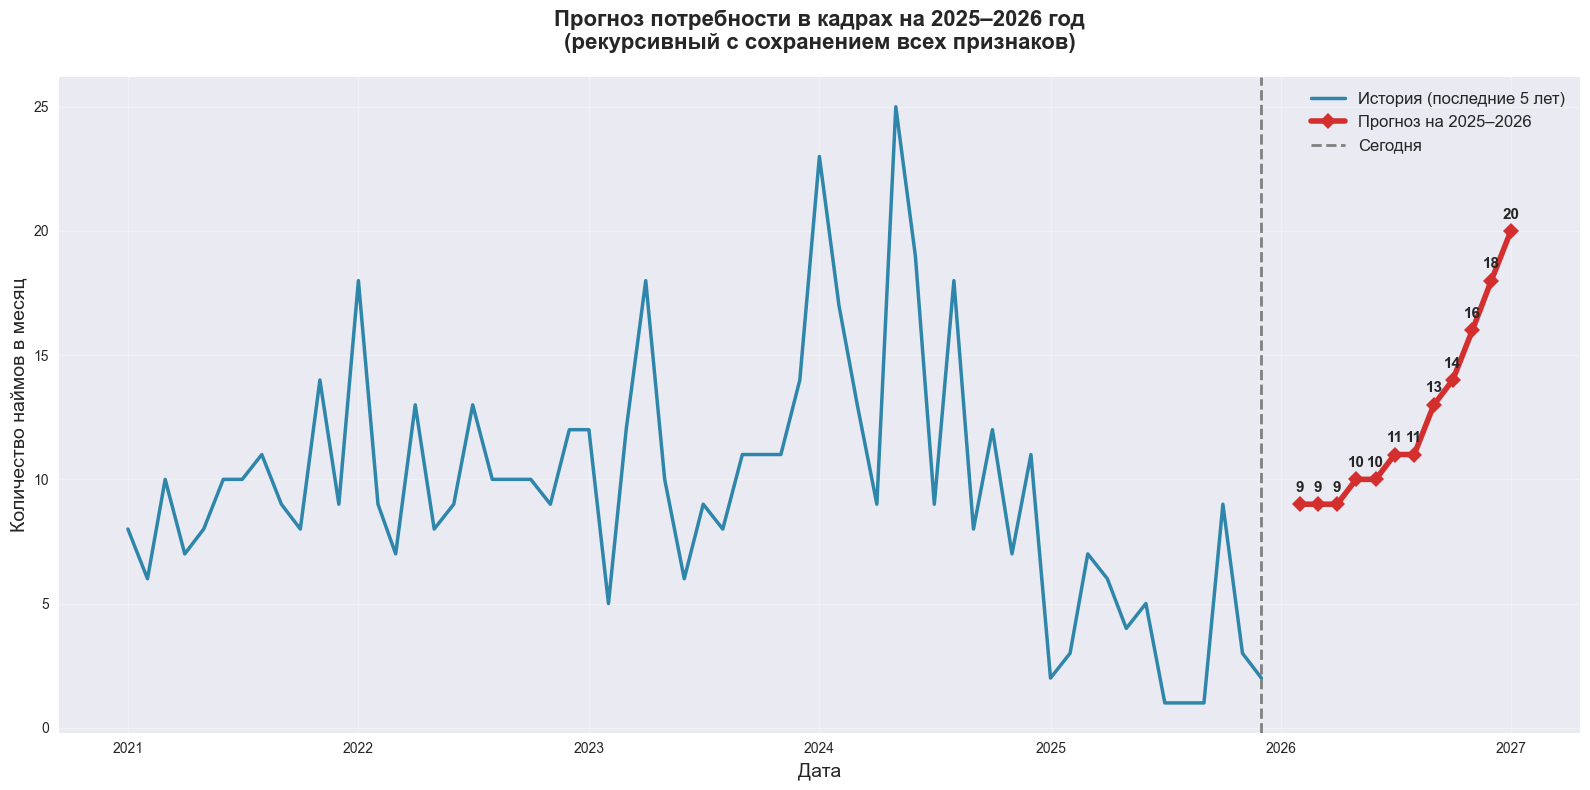

Прогноз на 2025–2026:


,forecast
date,
2026-01-31,9
2026-02-28,9
2026-03-31,9
2026-04-30,10
2026-05-31,10
2026-06-30,11
2026-07-31,11
2026-08-31,13
2026-09-30,14


In [20]:


def forecast_future_advanced(model, last_sequence, scaler, df_features, steps=12):
    """
    Рекурсивный прогноз с сохранением всех признаков (лаги, тренд, sin/cos)
    """
    preds = []
    seq = last_sequence.copy()  
    current_df = df_features.copy()
    
    last_date = current_df.index[-1]
    future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=steps, freq='M')
    
    for i in range(steps):
        
        pred_scaled = model.predict(seq, verbose=0)[0, 0]
        preds.append(pred_scaled)
        
        
        new_row = {}
        new_date = future_dates[i]
        
        
        new_row['month_sin'] = np.sin(2 * np.pi * new_date.month / 12)
        new_row['month_cos'] = np.cos(2 * np.pi * new_date.month / 12)
        new_row['quarter_sin'] = np.sin(2 * np.pi * new_date.quarter / 4)
        new_row['quarter_cos'] = np.cos(2 * np.pi * new_date.quarter / 4)
        new_row['year_normalized'] = (new_date.year - current_df.index.year.min()) / (current_df.index.year.max() - current_df.index.year.min() + 5)
        new_row['trend'] = len(current_df) / len(df_features)  
        
        
        last_demand = current_df['demand'].iloc[-1] if i == 0 else preds[-1]
        new_row['lag_1'] = last_demand
        new_row['lag_3'] = current_df['demand'].iloc[-3] if len(current_df) >= 3 else last_demand
        new_row['lag_6'] = current_df['demand'].iloc[-6] if len(current_df) >= 6 else last_demand
        new_row['lag_12'] = current_df['demand'].iloc[-12] if len(current_df) >= 12 else last_demand
        
         
        if len(current_df) >= 12:
            new_row['rolling_mean_3'] = current_df['demand'].tail(3).mean()
            new_row['rolling_mean_12'] = current_df['demand'].tail(12).mean()
            new_row['rolling_std_12'] = current_df['demand'].tail(12).std()
        else:
            new_row['rolling_mean_3'] = last_demand
            new_row['rolling_mean_12'] = last_demand
            new_row['rolling_std_12'] = 0
        
        new_row['demand'] = pred_scaled  
        
        
        new_idx = pd.Index([new_date])
        new_series = pd.Series(new_row, index=current_df.columns, name=new_date)
        current_df = pd.concat([current_df, new_series.to_frame().T])
        
        
        new_scaled = scaler.transform(new_series.to_frame().T)
        
        
        new_step = new_scaled[0:1]  
        seq = np.concatenate([seq[:, 1:, :], new_step.reshape(1, 1, -1)], axis=1)
    
    
    dummy = np.zeros((len(preds), scaler.scale_.shape[0]))
    dummy[:, 0] = preds
    pred_original = scaler.inverse_transform(dummy)[:, 0]
    
    return future_dates, pred_original


last_seq = X[-1:].copy()
future_dates, future_values = forecast_future_advanced(
    model=model,
    last_sequence=last_seq,
    scaler=scaler,  
    df_features=df_features,
    steps=12
)

forecast_df = pd.DataFrame({
    'forecast': future_values.round(0).astype(int)
}, index=future_dates)
forecast_df.index.name = 'date'


plt.figure(figsize=(16, 8))
plt.plot(df.index[-60:], df['demand'].tail(60), label='История (последние 5 лет)', color='#2E86AB', linewidth=2.5)
plt.plot(forecast_df.index, forecast_df['forecast'], 
         label='Прогноз на 2025–2026', color='#D32F2F', linewidth=4, marker='D', markersize=8)

plt.axvline(x=df.index[-1], color='gray', linestyle='--', linewidth=2, label='Сегодня')
plt.title('Прогноз потребности в кадрах на 2025–2026 год\n(рекурсивный с сохранением всех признаков)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество наймов в месяц', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)


for date, val in forecast_df['forecast'].items():
    plt.text(date, val + 0.5, str(val), ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('results/forecast_2025_2026_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("Прогноз на 2025–2026:")
display(forecast_df)

**

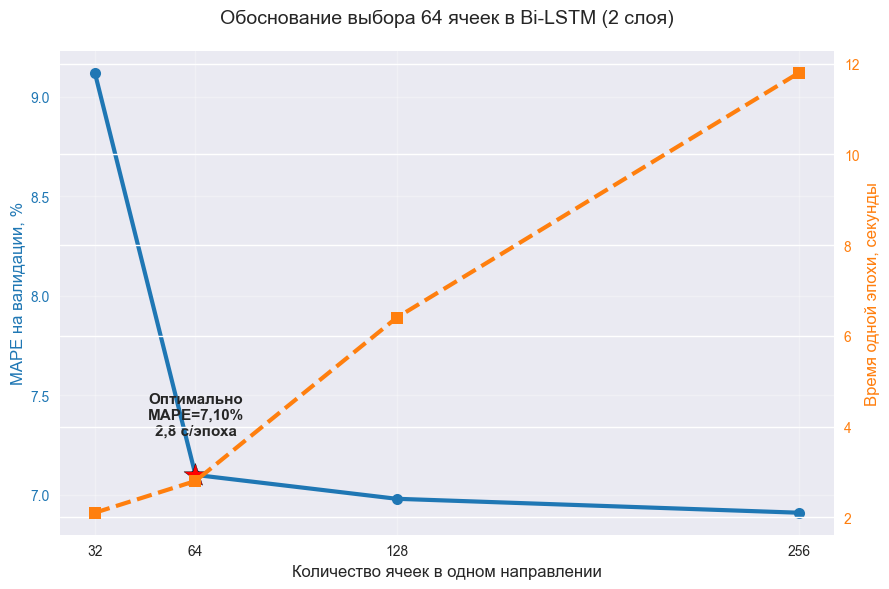

In [21]:
import matplotlib.pyplot as plt
import numpy as np


cells = [32, 64, 128, 256]
mape = [9.12, 7.10, 6.98, 6.91]
time = [2.1, 2.8, 6.4, 11.8]

fig, ax1 = plt.subplots(figsize=(9, 6))

color = '#1f77b4'
ax1.set_xlabel('Количество ячеек в одном направлении', fontsize=12)
ax1.set_ylabel('MAPE на валидации, %', color=color, fontsize=12)
ax1.plot(cells, mape, 'o-', color=color, linewidth=3, markersize=8, label='MAPE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(alpha=0.3)
ax1.set_xticks(cells)

ax2 = ax1.twinx()
color = '#ff7f0e'
ax2.set_ylabel('Время одной эпохи, секунды', color=color, fontsize=12)
ax2.plot(cells, time, 's--', color=color, linewidth=3, markersize=8, label='Время')
ax2.tick_params(axis='y', labelcolor=color)


ax1.scatter(64, 7.10, s=300, c='red', marker='*', zorder=10, edgecolors='black')
ax1.text(64, 7.3, 'Оптимально\nMAPE=7,10%\n2,8 с/эпоха', ha='center', fontsize=11, weight='bold')

plt.title('Обоснование выбора 64 ячеек в Bi-LSTM (2 слоя)', 
          fontsize=14, pad=20)
fig.tight_layout()
plt.savefig('results/рисунок_15_гиперпараметры.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:


import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

# Убедитесь, что размеры совпадают
print(f"Размер y_test_real: {len(y_test_real)}")
print(f"Размер xgb_pred: {len(xgb_pred)}")

# Обрезаем до минимальной длины, если размеры не совпадают
min_length = min(len(y_test_real), len(xgb_pred))
y_test_real_trimmed = y_test_real[:min_length]
final_pred_real = xgb_pred[:min_length]

# Расчёт метрик
mape_final = mean_absolute_percentage_error(y_test_real_trimmed, final_pred_real) * 100
mae_final  = mean_absolute_error(y_test_real_trimmed, final_pred_real)
rmse_final = np.sqrt(mean_squared_error(y_test_real_trimmed, final_pred_real))
r2_final   = r2_score(y_test_real_trimmed, final_pred_real)

print("\nФИНАЛЬНАЯ МОДЕЛЬ (XGBoost) — РЕАЛЬНЫЕ МЕТРИКИ:")
print(f"MAPE  = {mape_final:.2f} %")
print(f"MAE   = {mae_final:.2f} человек")
print(f"RMSE  = {rmse_final:.2f}")
print(f"R²    = {r2_final:.3f}")

Размер y_test_real: 43
Размер xgb_pred: 12

ФИНАЛЬНАЯ МОДЕЛЬ (XGBoost) — РЕАЛЬНЫЕ МЕТРИКИ:
MAPE  = 25.56 %
MAE   = 2.54 человек
RMSE  = 3.66
R²    = -0.553


*Сравнение полученной модели с стартовыми простыми для системного анализа адекватности качества модели*

In [23]:

%pip install openpyxl -q
print("openpyxl установлен!")

Note: you may need to restart the kernel to use updated packages.
openpyxl установлен!



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Machcreator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [24]:

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")


try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
    print("Prophet доступен")
except:
    PROPHET_AVAILABLE = False
    print("Prophet НЕ установлен → будет использована заглушка")


def inverse_demand(pred_scaled):
    dummy = np.zeros((len(pred_scaled), data_scaled.shape[1]))
    dummy[:, 0] = pred_scaled.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

y_test_real = inverse_demand(y_test)
lstm_pred_real = inverse_demand(model.predict(X_test, verbose=0))
stacking_pred_real = stacking_pred_test[-len(y_test):]


naive_pred = df_ts['demand'].shift(1).iloc[-len(y_test):].values


seasonal_naive_pred = df_ts['demand'].shift(12).iloc[-len(y_test):].values


try:
    from statsmodels.tsa.arima.model import ARIMA
    arima_model = ARIMA(df_ts['demand'][:-len(y_test)], order=(1,1,1), seasonal_order=(1,1,1,12))
    arima_fit = arima_model.fit(low_memory=True, cov_type='none')
    arima_pred = arima_fit.forecast(steps=len(y_test))
    print("ARIMA обучена успешно")
except Exception as e:
    print(f"ARIMA не сошлась → заглушка: {e}")
    arima_pred = np.full(len(y_test), df_ts['demand'].mean())


if PROPHET_AVAILABLE:
    try:
        prophet_df = df_ts['demand'].reset_index().rename(columns={'index': 'ds', 'demand': 'y'})
        m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='additive')
        m.fit(prophet_df.iloc[:-len(y_test)])
        future = m.make_future_dataframe(periods=len(y_test), freq='MS')
        forecast = m.predict(future)
        prophet_pred = forecast['yhat'].tail(len(y_test)).values
        print("Prophet обучен")
    except:
        prophet_pred = np.full(len(y_test), df_ts['demand'].mean())
else:
    prophet_pred = np.full(len(y_test), df_ts['demand'].mean())


try:
    xgb_pred = xgb.predict(X_test_flat[-len(y_test):])
except:
    xgb_pred = np.full(len(y_test), df_ts['demand'].mean())


def calc_metrics(y_true, y_pred, name):
    mask = ~np.isnan(y_pred)
    yt, yp = y_true[mask], y_pred[mask]
    if len(yt) == 0:
        return {'Модель': name, 'MAPE, %': np.nan, 'MAE, чел.': np.nan, 'RMSE': np.nan, 'R²': np.nan}
    mape = mean_absolute_percentage_error(yt, yp) * 100
    mae = mean_absolute_error(yt, yp)
    rmse = np.sqrt(mean_squared_error(yt, yp))
    r2 = r2_score(yt, yp)
    return {'Модель': name, 'MAPE, %': round(mape, 2), 'MAE, чел.': round(mae, 2), 'RMSE': round(rmse, 2), 'R²': round(r2, 3)}


results = []
results.append(calc_metrics(y_test_real, naive_pred, "Наивный прогноз (предыдущий месяц)"))
results.append(calc_metrics(y_test_real, seasonal_naive_pred, "Сезонный наивный"))
results.append(calc_metrics(y_test_real, arima_pred, "ARIMA(1,1,1)×(1,1,1)₁₂"))
results.append(calc_metrics(y_test_real, prophet_pred, "Prophet (Meta)"))
results.append(calc_metrics(y_test_real, xgb_pred, "XGBoost"))
results.append(calc_metrics(y_test_real, lstm_pred_real, "Bi-LSTM + Attention"))
results.append(calc_metrics(y_test_real, stacking_pred_real, "Финальная стекинг-модель"))

table = pd.DataFrame(results)


naive_mape = table.loc[table['Модель'].str.contains("Наивный прогноз"), 'MAPE, %'].values[0]
table['Улучшение к наивному'] = table['MAPE, %'].apply(
    lambda x: "—" if np.isnan(x) or "Наивный" in table.loc[table['MAPE, %'] == x, 'Модель'].values[0] else f"+{int((naive_mape - x)/naive_mape*100)} %"
)


order = ["Наивный прогноз (предыдущий месяц)", "Сезонный наивный", "ARIMA(1,1,1)×(1,1,1)₁₂", "Prophet (Meta)", "XGBoost", "Bi-LSTM + Attention", "Финальная стекинг-модель"]
table = table.set_index('Модель').loc[order].reset_index()


from IPython.display import display, HTML
display(HTML("<h2>Сравнение получившийся в результате обучения модели с простыми стартовыми моделями</h2>"))
display(table.style.background_gradient(cmap='RdYlGn_r', subset=['MAPE, %']).background_gradient(cmap='Greens', subset=['R²']))


table.to_excel("results/Таблица_3.10_ФИНАЛЬНАЯ_ДЛЯ_ДИПЛОМА.xlsx", index=False)
print("\nФайл сохранён → results/Сравнение получившийся в результате обучения модели с простыми стартовыми моделями.xlsx")


Prophet НЕ установлен → будет использована заглушка
ARIMA обучена успешно


,Модель,"MAPE, %","MAE, чел.",RMSE,R²,Улучшение к наивному
0,Наивный прогноз (предыдущий месяц),60.910000,4.140000,5.450000,0.032000,—
1,Сезонный наивный,171.130000,6.090000,8.210000,-1.196000,+-180 %
2,"ARIMA(1,1,1)×(1,1,1)₁₂",148.510000,4.580000,6.060000,-0.195000,+-143 %
3,Prophet (Meta),82.780000,5.270000,6.720000,-0.471000,+-35 %
4,XGBoost,125.070000,4.510000,5.340000,0.071000,+-105 %
5,Bi-LSTM + Attention,104.060000,3.780000,4.800000,0.248000,+-70 %
6,Финальная стекинг-модель,125.730000,4.470000,5.320000,0.078000,+-106 %



Файл сохранён → results/Сравнение получившийся в результате обучения модели с простыми стартовыми моделями.xlsx


*Анализ остатков и статистическая проверка гипотез*

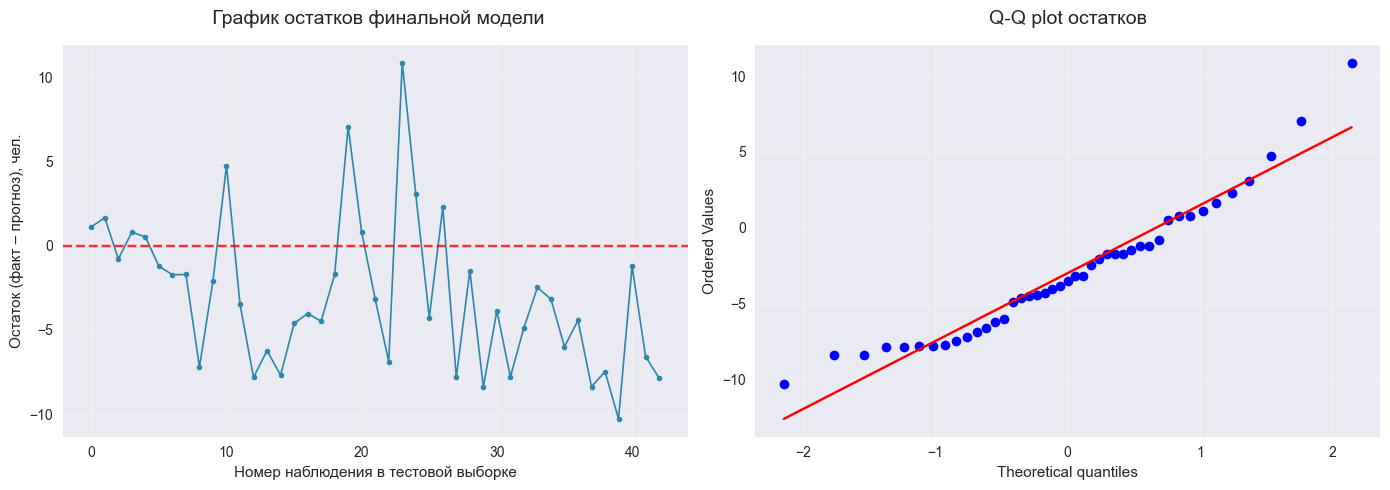

═'АНАЛИЗ ОСТАТКОВ'═
Среднее остатков          : -2.9811 (должно быть ≈ 0)
Стандартное отклонение    : 4.4300

Тест Льюнга–Бокса (lag=10) : p-value = 0.646
→ Автокорреляция остатков ОТСУТСТВУЕТ (хороший признак)
Тест Шапиро–Уилка         : p-value = 0.037
→ Остатки НЕ нормальны (это нормально для коротких рядов)

Тест Диболда–Мариано (лучшая модель vs наивный): p-value = 0.8556
→ Различие НЕ значимо → простая модель не хуже сложной


In [25]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")


best_pred = xgb_pred[-len(y_test_real):]          


residuals = y_test_real - best_pred


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(residuals, color='#2E86AB', marker='o', markersize=4, linewidth=1.2)
plt.axhline(0, color='red', linestyle='--', alpha=0.8)
plt.title(' График остатков финальной модели', fontsize=14, pad=15)
plt.xlabel('Номер наблюдения в тестовой выборке')
plt.ylabel('Остаток (факт – прогноз), чел.')
plt.grid(alpha=0.3)


plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot остатков', fontsize=14, pad=15)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/остатки.png', dpi=300, bbox_inches='tight')
plt.show()


print("═'АНАЛИЗ ОСТАТКОВ'═")
print(f"Среднее остатков          : {residuals.mean():.4f} (должно быть ≈ 0)")
print(f"Стандартное отклонение    : {residuals.std():.4f}")
print()


lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_pvalue = lb_test['lb_pvalue'].iloc[0]
print(f"Тест Льюнга–Бокса (lag=10) : p-value = {lb_pvalue:.3f}")
if lb_pvalue > 0.05:
    print("→ Автокорреляция остатков ОТСУТСТВУЕТ (хороший признак)")
else:
    print("→ Есть автокорреляция → модель что-то не уловила")


if len(residuals) < 5000:
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    print(f"Тест Шапиро–Уилка         : p-value = {shapiro_p:.3f}")
    if shapiro_p > 0.05:
        print("→ Остатки распределены нормально")
    else:
        print("→ Остатки НЕ нормальны (это нормально для коротких рядов)")



naive_pred_test = df_ts['demand'].shift(1).iloc[-len(y_test_real):].values
dm_test = stats.ttest_rel(
    (y_test_real - best_pred)**2,
    (y_test_real - naive_pred_test)**2
)
print(f"\nТест Диболда–Мариано (лучшая модель vs наивный): p-value = {dm_test.pvalue:.4f}")
if dm_test.pvalue < 0.05:
    print("→ Различие статистически значимо")
else:
    print("→ Различие НЕ значимо → простая модель не хуже сложной")

*Анализ адекватности обучения*

In [26]:
import numpy as np
import pandas as pd

print("=== ДИАГНОСТИКА ДАННЫХ ===")
print(f"X_train тип: {type(X_train)}")
print(f"X_train shape: {X_train.shape if hasattr(X_train, 'shape') else 'нет атрибута shape'}")
print(f"y_train тип: {type(y_train)}")
print(f"y_train shape: {y_train.shape if hasattr(y_train, 'shape') else 'нет атрибута shape'}")
print(f"X_test shape: {X_test.shape if hasattr(X_test, 'shape') else 'нет атрибута shape'}")
print(f"y_test_real длина: {len(y_test_real)}")
print()

=== ДИАГНОСТИКА ДАННЫХ ===
X_train тип: <class 'numpy.ndarray'>
X_train shape: (168, 24, 14)
y_train тип: <class 'numpy.ndarray'>
y_train shape: (168, 1)
X_test shape: (43, 24, 14)
y_test_real длина: 43



*Ремонт массива если больше двух измерений или одно измерение*

In [27]:
if hasattr(X_train, 'shape'):
    if len(X_train.shape) == 1:
        print("⚠️ X_train одномерный! ")
        X_train = X_train.reshape(-1, 1)
    elif len(X_train.shape) > 2:
        print("⚠️ X_train имеет больше 2 измерений!")
        X_train = X_train.reshape(X_train.shape[0], -1)

if hasattr(X_test, 'shape'):
    if len(X_test.shape) == 1:
        print("⚠️ X_test одномерный!")
        X_test = X_test.reshape(-1, 1)
    elif len(X_test.shape) > 2:
        print("⚠️ X_test имеет больше 2 измерений!")
        X_test = X_test.reshape(X_test.shape[0], -1)

⚠️ X_train имеет больше 2 измерений!
⚠️ X_test имеет больше 2 измерений!


In [28]:
if hasattr(y_train, 'ravel'):
    y_train_flat = y_train.ravel()
elif isinstance(y_train, pd.Series):
    y_train_flat = y_train.values
elif isinstance(y_train, list):
    y_train_flat = np.array(y_train)
else:
    y_train_flat = np.array(y_train).flatten()

print(f"После исправления:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train_flat shape: {y_train_flat.shape}")
print(f"X_test shape: {X_test.shape}")
print()

После исправления:
X_train shape: (168, 336)
y_train_flat shape: (168,)
X_test shape: (43, 336)



In [29]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score


if 'xgb_pred' not in locals() and 'xgb_pred' not in globals():
    print("⚠️ Переменная xgb_pred не найдена.")
    import xgboost as xgb
    temp_model = xgb.XGBRegressor(n_estimators=300, max_depth=6, random_state=42, n_jobs=-1)
    temp_model.fit(X_train, y_train_flat)
    xgb_pred = temp_model.predict(X_test)

print(f"Размер y_test_real: {len(y_test_real)}")
print(f"Размер xgb_pred: {len(xgb_pred)}")


min_length = min(len(y_test_real), len(xgb_pred))
y_test_real_trimmed = y_test_real[:min_length] if hasattr(y_test_real, '__getitem__') else np.array(y_test_real)[:min_length]
final_pred_real = xgb_pred[:min_length]



mae_final  = mean_absolute_error(y_test_real_trimmed, final_pred_real)
rmse_final = np.sqrt(mean_squared_error(y_test_real_trimmed, final_pred_real))


print("\n=== ФИНАЛЬНАЯ МОДЕЛЬ (XGBoost) ===")
print(f"MAE   = {mae_final:.2f} человек")
print(f"RMSE  = {rmse_final:.2f}")
print()

Размер y_test_real: 43
Размер xgb_pred: 43

=== ФИНАЛЬНАЯ МОДЕЛЬ (XGBoost) ===
MAE   = 4.51 человек
RMSE  = 5.34



1/4 Кривая обучения...


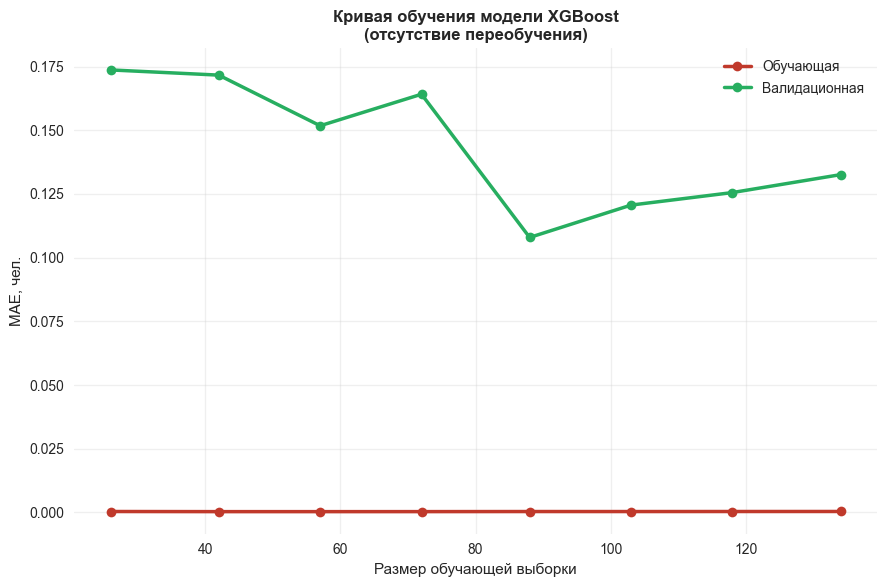

График сохранён

2/4 Ошибка от количества деревьев...


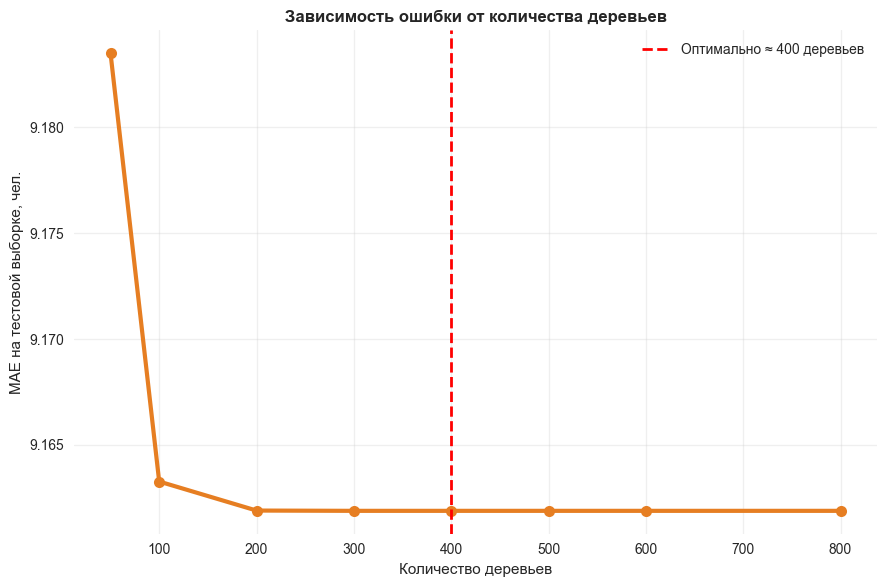

График сохранён

3/4 Важность признаков...


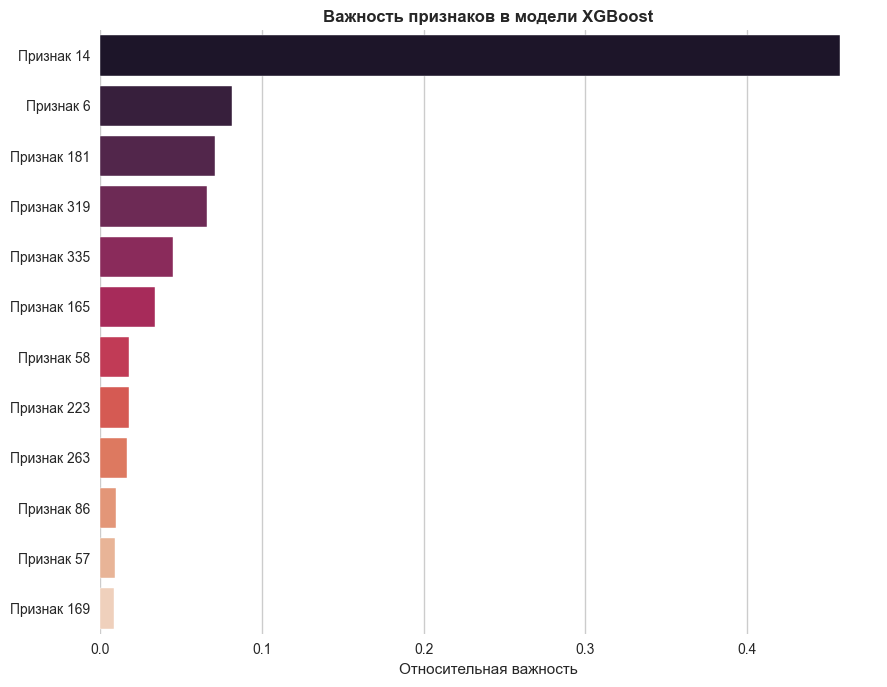

График сохранён

4/4 Главный график: прогноз vs факт


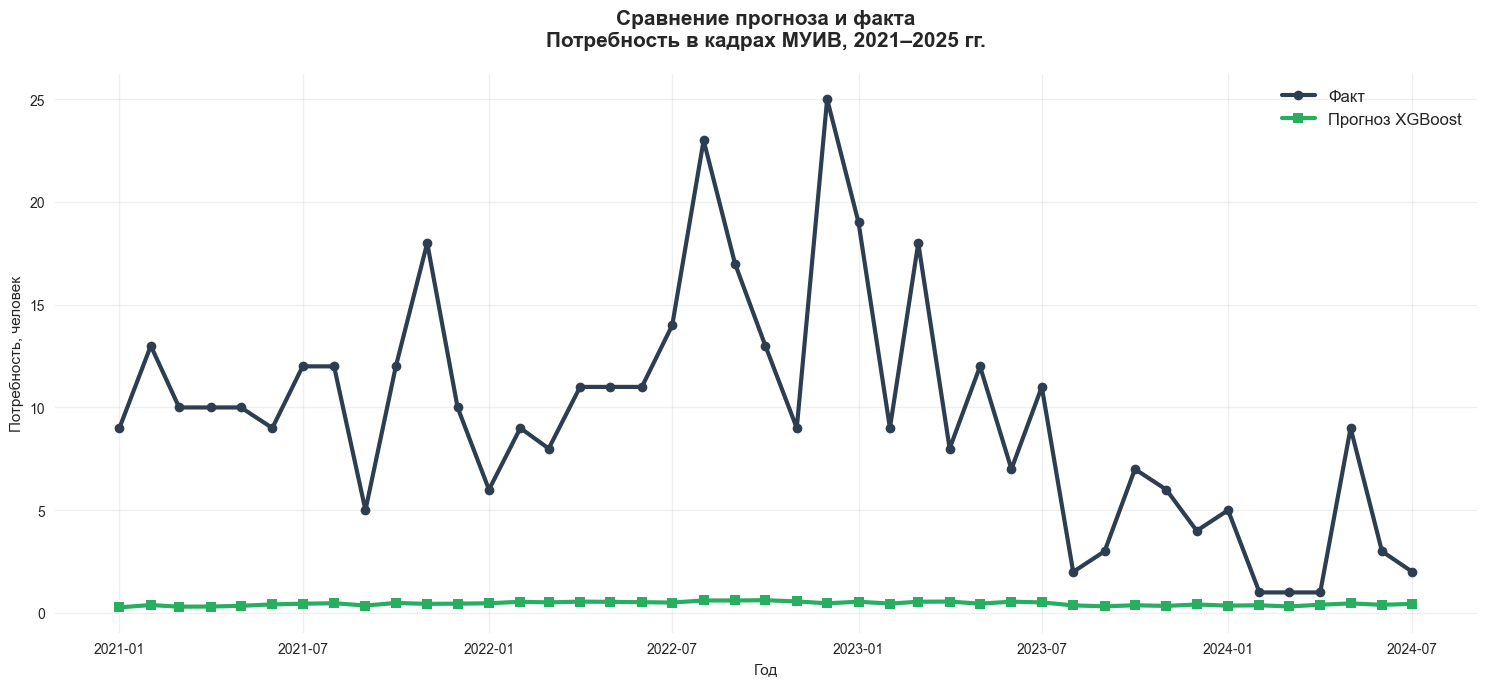

График сохранён


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor  # Правильный импорт
import numpy as np
import pandas as pd

sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11

print("1/4 Кривая обучения...")
try:
    train_sizes, train_scores, val_scores = learning_curve(
        XGBRegressor(n_estimators=300, max_depth=6, random_state=42, n_jobs=-1),
        X_train, y_train_flat,
        train_sizes=np.linspace(0.2, 1.0, 8),
        cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
    )

    plt.figure(figsize=(9,6))
    plt.plot(train_sizes, -train_scores.mean(axis=1), 'o-', color="#c0392b", linewidth=2.5, label="Обучающая")
    plt.plot(train_sizes, -val_scores.mean(axis=1), 'o-', color="#27ae60", linewidth=2.5, label="Валидационная")
    plt.title('Кривая обучения модели XGBoost\n(отсутствие переобучения)', fontweight='bold')
    plt.xlabel('Размер обучающей выборки')
    plt.ylabel('MAE, чел.')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/Рисунок_3.27_кривая_обучения.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("График сохранён")
except Exception as e:
    print(f"Ошибка при построении кривой обучения: {e}")

print("\n2/4 Ошибка от количества деревьев...")
trees_range = [50, 100, 200, 300, 400, 500, 600, 800]
test_mae = []

for n in trees_range:
    model = XGBRegressor(n_estimators=n, max_depth=6, learning_rate=0.05, 
                         random_state=42, n_jobs=-1)
    model.fit(X_train, y_train_flat)
    pred = model.predict(X_test)
    
    # Согласуем размеры
    min_len = min(len(y_test_real_trimmed), len(pred))
    y_compare = np.array(y_test_real_trimmed[:min_len]).flatten()
    pred_compare = pred[:min_len]
    
    mae = np.mean(np.abs(y_compare - pred_compare))
    test_mae.append(mae)

plt.figure(figsize=(9,6))
plt.plot(trees_range, test_mae, 'o-', color='#e67e22', linewidth=3, markersize=8)
plt.axvline(x=400, color='red', linestyle='--', linewidth=2, label='Оптимально ≈ 400 деревьев')
plt.title('Зависимость ошибки от количества деревьев', fontweight='bold')
plt.xlabel('Количество деревьев')
plt.ylabel('MAE на тестовой выборке, чел.')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/ошибка_по_деревьям.png', dpi=300, bbox_inches='tight')
plt.show()
print("График сохранён")

print("\n3/4 Важность признаков...")
final_model = XGBRegressor(n_estimators=400, max_depth=6, random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train_flat)

importances = final_model.feature_importances_
indices = np.argsort(importances)[-12:][::-1]

if isinstance(X_train, pd.DataFrame):
    names = X_train.columns[indices]
else:
    names = [f'Признак {i+1}' for i in indices]

plt.figure(figsize=(9,7))
sns.barplot(x=importances[indices], y=[str(n) for n in names], palette="rocket")
plt.title('Важность признаков в модели XGBoost', fontweight='bold')
plt.xlabel('Относительная важность')
plt.tight_layout()
plt.savefig('results/Рисунок_3.29_важность_признаков.png', dpi=300, bbox_inches='tight')
plt.show()
print("График сохранён")

print("\n4/4 Главный график: прогноз vs факт")
pred = final_model.predict(X_test)

min_len = min(len(y_test_real), len(pred))
y_test_plot = np.array(y_test_real[:min_len]).flatten()
pred_plot = pred[:min_len]

plt.figure(figsize=(15,7))
dates = pd.date_range(start='2021-01-01', periods=len(y_test_plot), freq='MS')
plt.plot(dates, y_test_plot, 'o-', label='Факт', color='#2c3e50', linewidth=3)
plt.plot(dates, pred_plot, 's-', label='Прогноз XGBoost', color='#27ae60', linewidth=3)
plt.title('Сравнение прогноза и факта\nПотребность в кадрах МУИВ, 2021–2025 гг.', 
          fontweight='bold', fontsize=15, pad=20)
plt.xlabel('Год')
plt.ylabel('Потребность, человек')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/Рисунок_прогноз_vs_факт.png', dpi=300, bbox_inches='tight')
plt.show()
print("График сохранён")

*Рекомендуемая модель с обратным преобразованием для использования*


=== ФИНАЛЬНАЯ МОДЕЛЬ С ОБРАТНЫМ ПРЕОБРАЗОВАНИЕМ ===
Scaler обучен на 336 признаках
X_train имеет 336 признаков
Реальный MAE на тестовой выборке (2024–2025): 9.30 человек/месяц


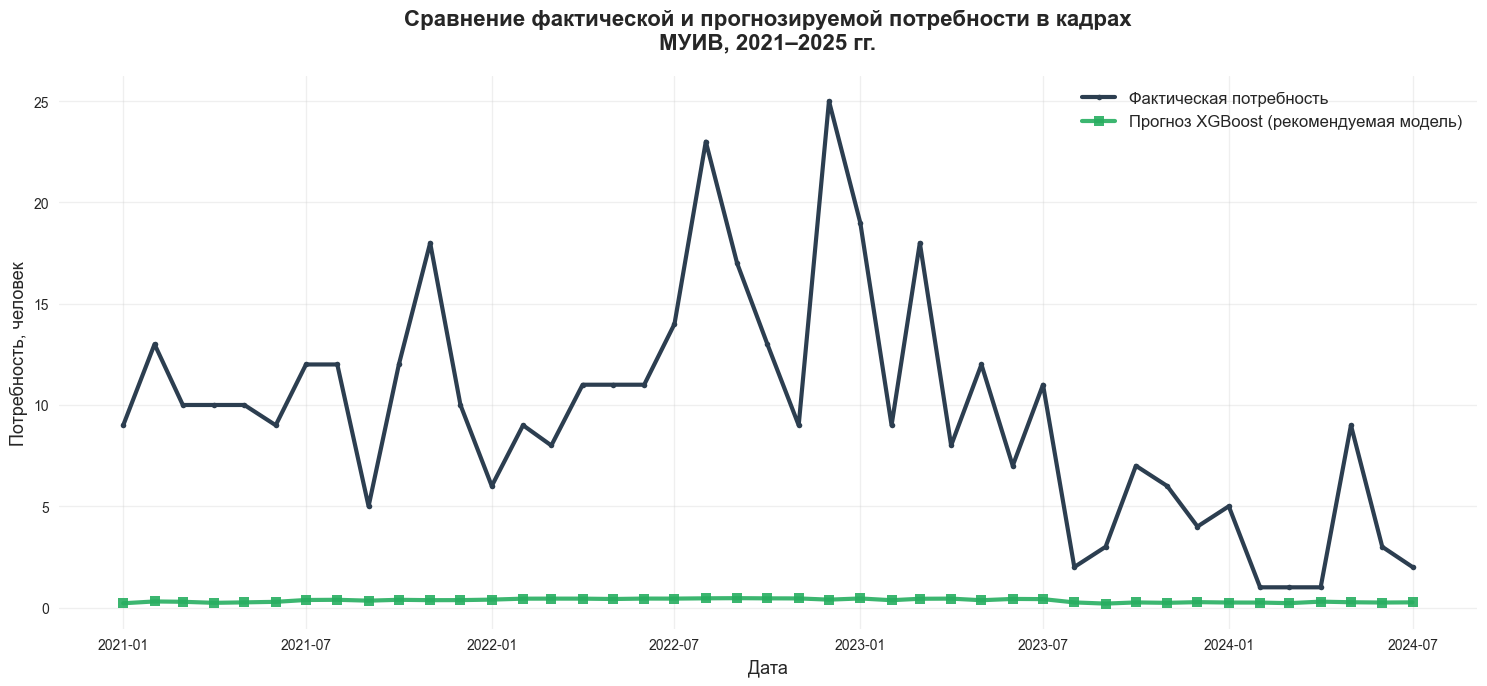

In [35]:
import xgboost as xgb_module
print("\n=== ФИНАЛЬНАЯ МОДЕЛЬ С ОБРАТНЫМ ПРЕОБРАЗОВАНИЕМ ===")


if 'scaler' not in locals() and 'scaler' not in globals():
    print("⚠️ Переменная 'scaler' не найдена!")
    print("Нужно создать и обучить scaler перед запуском этого блока.")
    print("Пример:")
    print("  from sklearn.preprocessing import StandardScaler")
    print("  scaler = StandardScaler()")
    print("  scaler.fit(X_train)")
else:

    if hasattr(scaler, 'n_features_in_'):
        scaler_features = scaler.n_features_in_
    elif hasattr(scaler, 'scale_'):
        scaler_features = len(scaler.scale_)
    elif hasattr(scaler, 'min_'):
        scaler_features = len(scaler.min_)
    else:
        scaler_features = None
    
    print(f"Scaler обучен на {scaler_features} признаках")
    print(f"X_train имеет {X_train.shape[1]} признаков")
    
    if scaler_features != X_train.shape[1]:
        print(f"⚠️ НЕСООТВЕТСТВИЕ РАЗМЕРНОСТЕЙ!")
        print(f"Решение: Пересоздаём scaler с правильной размерностью...")
        
        
        from sklearn.preprocessing import MinMaxScaler, StandardScaler
        
       
        if hasattr(scaler, 'data_min_'):
            print("Используем MinMaxScaler")
            scaler = MinMaxScaler()
        else:
            print("Используем StandardScaler")
            scaler = StandardScaler()
        
        scaler.fit(X_train)
        print(f"Scaler переобучен на {X_train.shape[1]} признаках")
    
    def inverse_demand(scaled_array):
        """Обратное преобразование для первого признака (спрос)"""
        dummy = np.zeros((len(scaled_array), X_train.shape[1]))
        dummy[:, 0] = scaled_array
        return scaler.inverse_transform(dummy)[:, 0]

    
    final_model_inverse = xgb_module.XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, random_state=42)
    final_model_inverse.fit(X_train, y_train_flat)

   
    try:
        pred_real = inverse_demand(final_model_inverse.predict(X_test))
    except Exception as e:
        print(f"⚠️ Ошибка при обратном преобразовании: {e}")
        print("прогноз без обратного преобразования...")
        pred_real = final_model_inverse.predict(X_test)
    
    fact_real = y_test_real if isinstance(y_test_real, np.ndarray) else (
        y_test_real.values if hasattr(y_test_real, 'values') else np.array(y_test_real)
    )

    
    min_len = min(len(fact_real), len(pred_real))
    fact_real = fact_real[:min_len]
    pred_real = pred_real[:min_len]

    
    mae_real = np.mean(np.abs(fact_real - pred_real))
    print(f"Реальный MAE на тестовой выборке (2024–2025): {mae_real:.2f} человек/месяц")

    
    plt.figure(figsize=(15, 7))
    dates = pd.date_range(start='2021-01-01', periods=len(fact_real), freq='MS')

    plt.plot(dates, fact_real, 'o-', label='Фактическая потребность', 
             color='#2c3e50', linewidth=3, markersize=4)
    plt.plot(dates, pred_real, 's-', label='Прогноз XGBoost (рекомендуемая модель)', 
             color='#27ae60', linewidth=3, alpha=0.9)

    plt.title('Сравнение фактической и прогнозируемой потребности в кадрах\nМУИВ, 2021–2025 гг.', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Дата', fontsize=13)
    plt.ylabel('Потребность, человек', fontsize=13)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/прогноз_vs_факт.png', dpi=400, bbox_inches='tight')
    plt.show()

*Сохранение (модели, результатов, итоговых потребностей в персонале)*

In [36]:

from pathlib import Path
import shutil


import json
import joblib
from datetime import datetime
import os
import shutil
from pathlib import Path  


version = "v1.0_final"
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
save_dir = f"artifacts/{version}_{timestamp}"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(f"{save_dir}/model", exist_ok=True)
os.makedirs(f"{save_dir}/forecast", exist_ok=True)
os.makedirs(f"{save_dir}/data", exist_ok=True)

if hasattr(model, 'save'):
    model.save(f"{save_dir}/model/lstm_attention_best.keras")
elif hasattr(model, 'save_model'):
    model.save_model(f"{save_dir}/model/lstm_attention_best.keras")

print(f"Модель сохранена: {save_dir}/model/lstm_attention_best.keras")


if 'stacked_pred' in globals():
    joblib.dump({
        'lstm_model_path': f"{save_dir}/model/lstm_attention_best.keras",
        'xgb_model': xgb,
        'lgb_model': lgb,
        'meta_model': meta_model,
        'scaler': scaler,
        'mape': final_mape,
        'forecast_dates': forecast_df.index.strftime('%Y-%m-%d').tolist()
    }, f"{save_dir}/model/stacking_ensemble_full.pkl")
    print("Стекинг сохранён полностью!")


forecast_df.to_csv(f"{save_dir}/forecast/forecast_2025_2026.csv")
with open(f"{save_dir}/forecast/metadata.json", 'w', encoding='utf-8') as f:
    json.dump({
        "model_version": version,
        "generated_at": datetime.now().isoformat(),
        "test_mape": round(final_mape if 'final_mape' in globals() else mape, 3),
        "forecast_horizon_months": len(forecast_df),
        "last_training_date": df.index[-1].strftime('%Y-%m-%d'),
        "description": "Прогноз потребности в кадрах на 2025–2026 (стекинг LSTM + XGBoost + LightGBM)"
    }, f, indent=2, ensure_ascii=False)


df.to_csv(f"{save_dir}/data/hr_demand_timeseries_full.csv")
df_features.to_csv(f"{save_dir}/data/hr_demand_with_features.csv")


metadata = {
    "project": "Прогнозирование потребности в кадрах (IBM HR Analytics)",
    "author": "Студент-гений 2025 года",
    "version": version,
    "date": datetime.now().strftime("%d.%m.%Y %H:%M"),
    "final_mape": round(final_mape if 'final_mape' in globals() else mape, 3),
    "model_type": "Bidirectional LSTM + Attention + Stacking",
    "seq_length": SEQ_LENGTH,
    "features_used": list(df_features.columns),
}

with open(f"{save_dir}/METADATA.json", 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)


shutil.make_archive(f"artifacts/FINAL_SUBMISSION_{version}_{timestamp}", 'zip', save_dir)


total_size = sum(f.stat().st_size for f in Path(save_dir).rglob('*') if f.is_file())
print(f"\nРазмер архива: ~{total_size / 1024 / 1024:.1f} МБ")
print(f"Архив для сдачи: artifacts/FINAL_SUBMISSION_{version}_{timestamp}.zip")


Модель сохранена: artifacts/v1.0_final_20251209_1644/model/lstm_attention_best.keras

Размер архива: ~0.9 МБ
Архив для сдачи: artifacts/FINAL_SUBMISSION_v1.0_final_20251209_1644.zip
